# Анализ системы метрик развлекательного приложения

* Егорова Ольга

## Введение

Приложение Procrastinate Pro+ предоставляет пользователям доступ к развлекательному контенту: видео, подкастам и блогам. Пользователи могут выбрать несколько пакетов контента. Пакеты различаются по цене, объёму и содержанию.

К началу лета в приложении появился новый вид контента — спортивный. С его помощью менеджеры стремятся расширить аудиторию, добавив в неё пользователей, которые увлекаются спортом и здоровым образом жизни.

К запуску нового контента была скорректирована маркетинговая стратегия привлечения пользователей. Согласно бизнес-модели продукта, привлечение должно окупиться за первые 28 дней (4 недели).

После запуска нового контента и изменения стратегии интерес к продукту в целом вырос, но выручка начала стагнировать. Нужно разобраться, почему это происходит.

## Задачи

- провести анализ юнит-экономики продукта в динамике за первые 28 дней;
- разобраться в причинах стагнации выручки;
- определить, какие источники привлечения приносят прибыль, а какие не выходят на уровень окупаемости;
- дать рекомендации отделу маркетинга.

## Данные

В распоряжении есть данные о посещениях приложения, покупках и расходах на маркетинг. Данные собраны в трёх датасетах.

1. Датасет `ppro_visits.csv` — информация о посещениях приложения пользователями, которые зарегистрировались с 1 апреля 2024 года по 30 ноября 2024 года:
    - `user_id` — уникальный идентификатор пользователя;
    - `region` — страна пользователя;
    - `device` — категория устройства пользователя;
    - `channel` — идентификатор рекламного источника, из которого пришёл пользователь;
    - `session_start` — дата и время начала сессии;
    - `session_end` — дата и время окончания сессии.

2. Датасет `ppro_orders.csv` — информация о покупках:
    - `user_id` — уникальный идентификатор пользователя, который сделал покупку;
    - `event_dt` — дата и время покупки;
    - `revenue` — выручка.

3. Датасет `ppro_costs.csv` — информация о затратах на маркетинг:
    - `dt` — дата
    - `channel` — идентификатор рекламного источника;
    - `costs` — затраты на этот рекламный источник в этот день.

## План проекта

- Загрузить и предобработать данные.
- Подготовить данные для когортного анализа.
- Рассчитать и проанализировать метрики вовлечённости в продукт.
- Рассчитать и проанализировать финансовые метрики CAC, LTV и ROI за первые 28 дней с момента привлечения.
- Исследовать метрики в разрезе источника привлечения.
- Рассчитать период окупаемости маркетинговых вложений.
- Сформулировать выводы и рекомендации.

## Загрузка и предобработка данных

### Настройка окружения и загрузка данных

In [ ]:
pip install matplotlib==3.4.0 

In [1]:
# Загружаем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

In [2]:
# Ссылка для ppro_visits.csv
url1 = 'https://drive.google.com/uc?export=download&id=1OKMfXQ1B5iPkeTn0WsNePFLXA7DXbEXr'
# Ссылка для ppro_orders.csv
url2 = 'https://drive.google.com/uc?export=download&id=1tJlL3zKac4br_REJwYPOgANv0T6u2kU9'
# Ссылка для ppro_costs.csv
url3 = 'https://drive.google.com/uc?export=download&id=1f7sQYmoT93f0I9hvxEIW1pcOnO_j5Irb'

# Создаём датафреймы
# Из описания данных уже понятно, в каких столбцах содержится дата и время, поэтому
# в функцию read_csv() передадим аргумент parse_dates с именами столбцов, содержащих даты
# для  преобразования их к типу datetime64[ns]
df_visits = pd.read_csv(url1, parse_dates=['session_start','session_end'])
df_orders = pd.read_csv(url2, parse_dates=['event_dt'])
df_costs = pd.read_csv(url3, parse_dates=['dt'])

### Знакомство с данными

**Посмотрим на первые строки созданных датафреймов:**

In [3]:
df_visits.head()

,user_id,region,device,channel,session_start,session_end
0,631105188566,India,desktop,MediaTornado,2024-04-01 03:48:00,2024-04-01 04:19:00
1,892885906464,India,tv,RocketSuperAds,2024-04-01 00:47:00,2024-04-01 01:14:00
2,517003690029,India,mobile,MediaTornado,2024-04-01 17:31:00,2024-04-01 17:53:00
3,185156659289,India,mobile,MediaTornado,2024-04-01 14:36:00,2024-04-01 14:51:00
4,409503040345,India,mobile,RocketSuperAds,2024-04-01 08:25:00,2024-04-01 08:45:00


In [4]:
df_orders.head()

,user_id,event_dt,revenue
0,771951256319,2024-04-01 05:56:26,2.99
1,829942381059,2024-04-01 14:55:02,2.99
2,727879856738,2024-04-01 22:15:09,14.99
3,481270888930,2024-04-01 06:05:14,2.99
4,844695029762,2024-04-01 01:19:52,2.99


In [5]:
df_costs.head()

,dt,channel,costs
0,2024-04-01,FaceBoom,124.938874
1,2024-04-02,FaceBoom,88.147779
2,2024-04-03,FaceBoom,120.779457
3,2024-04-04,FaceBoom,98.981253
4,2024-04-05,FaceBoom,109.044760


**Выведем основную информацию о датафреймах:**

In [6]:
print('___df_visits___')
print(' ')
df_visits.info()
print(' ')
print('___df_orders___')
print(' ')
df_orders.info()
print('  ')
print('___df_costs___')
print(' ')
df_costs.info()

___df_visits___
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161865 entries, 0 to 161864
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        161865 non-null  int64         
 1   region         161865 non-null  object        
 2   device         161865 non-null  object        
 3   channel        161865 non-null  object        
 4   session_start  161865 non-null  datetime64[ns]
 5   session_end    161865 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 7.4+ MB
 
___df_orders___
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33893 entries, 0 to 33892
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   33893 non-null  int64         
 1   event_dt  33893 non-null  datetime64[ns]
 2   revenue   33893 non-null  float64       
dtypes: datetime64[ns](1), fl

**Названия столбцов корректны и удобны для работы. Типы данных корректны: поля с идетификатором пользователей имеют тип `int64`; поля с датой и временем имеют тип `datetime64[ns]`; текстовые поля `region`, `device` и `channel` имеют тип `object`; поля содержащие выручку и затраты имеют тип `float64`** 

### Проверка на наличие пропусков

In [7]:
# Проверим наличие полных дубликатов
print('Количество пропущенных значений в df_visits: ', df_visits.isna().sum().sum())
print('Количество пропущенных значений в df_orders: ', df_orders.isna().sum().sum())
print('Количество пропущенных значений в df_costs: ', df_costs.isna().sum().sum())

Количество пропущенных значений в df_visits:  0
Количество пропущенных значений в df_orders:  0
Количество пропущенных значений в df_costs:  0


### Проверка на наличие дубликатов

In [8]:
# Проверим наличие полных дубликатов
print('Количество полных дубликатов в df_visits: ', df_visits.duplicated().sum())
print('Количество полных дубликатов в df_orders: ', df_orders.duplicated().sum())
print('Количество полных дубликатов в df_costs: ', df_costs.duplicated().sum())

Количество полных дубликатов в df_visits:  0
Количество полных дубликатов в df_orders:  0
Количество полных дубликатов в df_costs:  0


### Временной диапазон

Проверим интервалы дат в каждом датафрейме, чтобы понять полный охват данных и есть ли выбросы дат за пределами ожидаемого диапазона.

In [9]:
# Выводим описательную статистику полей с датой и временем датфрейма df_visits
print('___df_visits___')
df_visits[['session_start', 'session_end']].describe()

___df_visits___


,session_start,session_end
count,161865,161865
mean,2024-08-13 00:20:43.344639232,2024-08-13 00:50:48.320637696
min,2024-04-01 00:07:00,2024-04-01 00:22:00
25%,2024-06-16 01:27:00,2024-06-16 02:01:00
50%,2024-08-18 10:58:00,2024-08-18 11:37:00
75%,2024-10-13 05:19:00,2024-10-13 05:54:00
max,2024-11-30 23:59:00,2024-12-01 01:40:00


* **Самая ранняя сессия:** 2024-04-01 00:07:00 (начало сессии), 2024-04-01 00:22:00 (конец сессии).  
* **Самая поздняя сессия:** 2024-11-30 23:59:00 (начало сессии), 2024-12-01 01:40:00 (конец сессии).
* **Данные охватывают:** 8 месяц с 1 апреля по 30 ноября 2024 года

In [10]:
# Выводим описательную статистику полей с датой и временем датфрейма df_orders
print('___df_orders___')
df_orders[['event_dt']].describe()

___df_orders___


,event_dt
count,33893
mean,2024-08-26 21:44:54.734783232
min,2024-04-01 00:53:40
25%,2024-07-09 00:09:10
50%,2024-09-04 20:08:09
75%,2024-10-22 01:27:22
max,2024-11-30 23:55:50


* **Самая раннее событие:** 2024-04-01 00:53:40.  
* **Самая позднее событие:** 2024-11-30 23:55:50.
* **Данные охватывают:** 8 месяц с 1 апреля по 30 ноября 2024 года

In [11]:
# Выводим описательную статистику полей с датой и временем датфрейма df_costs
print('___df_costs___')
df_costs[['dt']].describe()

___df_costs___


,dt
count,976
mean,2024-07-31 12:00:00
min,2024-04-01 00:00:00
25%,2024-05-31 18:00:00
50%,2024-07-31 12:00:00
75%,2024-09-30 06:00:00
max,2024-11-30 00:00:00


* **Самое раннее событие:** 2024-04-01 00:00:00.  
* **Самое позднее событие:** 2024-11-30 00:00:00.
* **Данные охватывают:** 8 месяц с 1 апреля по 30 ноября 2024 года

**Данные охватывают один диапазон с 1 апреля по 30 ноября 2024 года**

### Источники привлечения

Проверим, что источники привлечения одинаковы в данных с событиями df_visits и в данных с затратами df_costs.

In [12]:
# Источники привлечения в датафрейме df_visits
df_visits['channel'].unique()

array(['MediaTornado', 'RocketSuperAds', 'FaceBoom', 'TipTop'],
      dtype=object)

In [13]:
# Источники привлечения в датафрейме df_costs
df_costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop'],
      dtype=object)

**В данных используются одинаковые источники привлечениия `FaceBoom`, `MediaTornado`, `RocketSuperAds`, `TipTop`**

### Пользователи приложения

Проверим, что все пользователи, которые совершили покупки по данным из `df_orders`, есть в таблице с логами событий `df_visits`.

In [14]:
# Количество пользователей, совершавших покупки из датафрейме df_orders
df_orders['user_id'].nunique()

6889

In [15]:
# Количество пользователей, совершавших какие-либо действия из датафрейме df_visits
df_visits['user_id'].nunique()

74856

Проверим, является ли множество пользователей из датафрейме `df_orders` подмножеством  датафрейма `df_visits` с помощью метода `.issubset()`:

In [16]:
# множеств опользователей из датафрейме df_orders
users_orders = set(df_orders['user_id'].unique())

# множеств опользователей из датафрейме df_visits
users_visits = set(df_visits['user_id'].unique())

# Проверим является ли множество users_orders  подмножеством множества users_visits
users_orders.issubset(users_visits)

True

**Метод `.issubset()` возвращает `True`, значит для всех пользователей совершившие покупки (из датафрейме `df_orders`) есть записи о сессиях (в датафрейме `df_visits`).**

### Сессии продолжительностью 0 минут

**Определим, есть ли в данных записи с продолжительностью сессий 0 минут.** Такие сессиий могут быть, например, результатом случайного запуска приложения и в этом случае не могут считаться полноценными сессиями. Если такие сессии есть, определим, совершались ли в рамках этих сессиий покупки. 

In [17]:
# Найдем продолжительность каждой сесии в секундах и переведем в минуты
df_visits['session_duration'] = (df_visits['session_end'] - df_visits['session_start']).dt.total_seconds() / 60 

# Найдем количество записей с длительностью сессии 0 минут
print('Количество сессий продолжительностью 0 минут:', df_visits[df_visits['session_duration'] == 0].shape[0])

Количество сессий продолжительностью 0 минут: 2686


In [18]:
# Посмотрим, совершали ли эти пользователи покупки
# Найдем пересечение множеств идентификаторов пользователей совершивших покупки и 
# идентификаторов пользователей, имеющих продолжительность сессии 0 минут 
# и выведем число общих элементов
len(set(df_orders['user_id']) & set(df_visits[df_visits['session_duration'] == 0]['user_id']))


712

**Из 2686 пользователей 712 совершили в рамках своих сессий продолжительность ноль минут (несколько секунд) покупки. Значит сессии продолжительностью несколько секунд (ноль минут) нельзя отнести к случайным. Оставим записи без удаления.**

## Подготовка данных к когортному анализу

### Дополнительные поля в датафрейме  `df_visits` с данными об активности пользователей

Добавим в датафрейма  с информацией о взаимодействии пользователей с приложением `df_visits` поля с **днем и месяцем активности в приложении**

In [19]:
# Создаем поле с днем активности каждого пользователя
df_visits['event_day'] = df_visits['session_start'].dt.to_period('D')

In [20]:
# Создаем поле с первой неделей посещения приложения каждым пользователем
df_visits['event_week'] = df_visits['session_start'].dt.to_period('W').dt.start_time

In [21]:
# Создаем поле с месяцем активности каждого пользователя
df_visits['event_month'] = df_visits['session_start'].dt.to_period('M')

In [22]:
df_visits.head()

,user_id,region,device,channel,session_start,session_end,session_duration,event_day,event_week,event_month
0,631105188566,India,desktop,MediaTornado,2024-04-01 03:48:00,2024-04-01 04:19:00,31.0,2024-04-01,2024-04-01,2024-04
1,892885906464,India,tv,RocketSuperAds,2024-04-01 00:47:00,2024-04-01 01:14:00,27.0,2024-04-01,2024-04-01,2024-04
2,517003690029,India,mobile,MediaTornado,2024-04-01 17:31:00,2024-04-01 17:53:00,22.0,2024-04-01,2024-04-01,2024-04
3,185156659289,India,mobile,MediaTornado,2024-04-01 14:36:00,2024-04-01 14:51:00,15.0,2024-04-01,2024-04-01,2024-04
4,409503040345,India,mobile,RocketSuperAds,2024-04-01 08:25:00,2024-04-01 08:45:00,20.0,2024-04-01,2024-04-01,2024-04


### Датафрейм с данными о пользователях, их первом канале привлечения и первой дате активности

- Агрегируем данные датафрейма с информацией о взаимодействии пользователей с приложением `df_visits`, чтобы получить **для каждого пользователя  первый день активности** 

In [23]:
# Сортируем данные по полю session_start для корректных расчетов
df_visits.sort_values(by=['session_start'], inplace=True)

In [24]:
# Агрегируем данные, сгруппировав по пользователю, найдем первый день активности
df_visits_first = df_visits.groupby(['user_id'])['session_start'].min().reset_index()
df_visits_first.head()

,user_id,session_start
0,26034876,2024-05-29 10:24:00
1,69890364,2024-06-28 05:48:00
2,75610104,2024-06-09 06:48:00
3,76692397,2024-10-21 01:51:00
4,80224421,2024-06-21 11:47:00


- Учитывая, что пользователь может переходить в приложение через разные каналы привлечения, необходимо найти **первый канал привлечения для каждого пользователя**.
На основе связки "идентификатор пользователя + дата и время первого посещения", присоединим к датафрейму `df_visits_first` название канала привлечения из `df_visits`.

In [25]:
# Присоединяем название первого канала привлечения
df_visits_first = df_visits_first.merge(
    df_visits[['user_id','session_start','channel']], on=['user_id','session_start'], how='left'
)

In [26]:
# Переименовываем столбец с названием канала привлечения в 'first_channel'
df_visits_first = df_visits_first.rename(columns={'channel':'first_channel'})
df_visits_first.head()

,user_id,session_start,first_channel
0,26034876,2024-05-29 10:24:00,FaceBoom
1,69890364,2024-06-28 05:48:00,RocketSuperAds
2,75610104,2024-06-09 06:48:00,FaceBoom
3,76692397,2024-10-21 01:51:00,FaceBoom
4,80224421,2024-06-21 11:47:00,FaceBoom


* Добавим поле с **первым днем посещения** пользователя `first_day` и с **первой неделей посещения** пользователя `first_week`на основе поля `session_start`. Эти поля помогут в дальнейшем агрегировать данные.

In [27]:
# Создаем поле с первой неделей посещения приложения каждым пользователем
df_visits_first['first_week'] = df_visits_first['session_start'].dt.to_period('W').dt.start_time

In [28]:
# Создаем поле с первой датой посещения приложения каждым пользователем в формате Period[D]
df_visits_first['first_day'] = df_visits_first['session_start'].dt.to_period('D')

In [29]:
# Оставим нужные столбцы
df_visits_first = df_visits_first[['user_id', 'first_channel','first_week','first_day']]

In [30]:
df_visits_first.head()

,user_id,first_channel,first_week,first_day
0,26034876,FaceBoom,2024-05-27,2024-05-29
1,69890364,RocketSuperAds,2024-06-24,2024-06-28
2,75610104,FaceBoom,2024-06-03,2024-06-09
3,76692397,FaceBoom,2024-10-21,2024-10-21
4,80224421,FaceBoom,2024-06-17,2024-06-21


**Датафрейм `df_visits_first` содержит данные о пользователе,  первом канале привлечения и первой дате и недели активности** 

### Датафрейм с данными о затратах, количестве привлеченных пользователей и стоимостью привлечения одного пользователя по каждому каналу за каждый день

* Добавим первый день и первую неделю в датафрейм с затратами `df_costs`

In [31]:
# Добавим поле с первой неделей
df_costs['first_week'] = df_costs['dt'].dt.to_period('W').dt.start_time

In [32]:
# Добавим поле first_day, преобразовав поле `dt` талбицы 'df_costs' в формат Period[D]:
df_costs['first_day'] = df_costs['dt'].dt.to_period('D')

In [33]:
df_costs.head()

,dt,channel,costs,first_week,first_day
0,2024-04-01,FaceBoom,124.938874,2024-04-01,2024-04-01
1,2024-04-02,FaceBoom,88.147779,2024-04-01,2024-04-02
2,2024-04-03,FaceBoom,120.779457,2024-04-01,2024-04-03
3,2024-04-04,FaceBoom,98.981253,2024-04-01,2024-04-04
4,2024-04-05,FaceBoom,109.044760,2024-04-01,2024-04-05


* Найдем **стоимость привлечения каждого пользователя**.  
Для этого агрегируем данные датафрейма `df_visits_first` и для каждого первого дня и первого канала привлечения найдем число пользователей, то есть узнаем сколько пользователей было привлечено в конкретный день по конкретному каналу.  
Из датафрейма `df_costs` добавим затраты по дням и каналам и рассчитаем стоимость привлечения одного пользователя в зависимости от дня привлечения и канала привлечения.

In [34]:
# Найдем для каждого дня и каждого канала привлечения количество пользователей
df_users_count = df_visits_first.groupby(
    ['first_day', 'first_channel'])['user_id'].count().reset_index(name='users_count')
df_users_count.head()

,first_day,first_channel,users_count
0,2024-04-01,FaceBoom,133
1,2024-04-01,MediaTornado,80
2,2024-04-01,RocketSuperAds,70
3,2024-04-01,TipTop,73
4,2024-04-02,FaceBoom,94


In [35]:
# Объединим данные о затратах из 'df_costs' и количестве пользователей из 'df_users_count'
df_cac = df_costs.merge(
    df_users_count, right_on=['first_day','first_channel'], left_on=['first_day','channel'], how='left'
)
df_cac.head()

,dt,channel,costs,first_week,first_day,first_channel,users_count
0,2024-04-01,FaceBoom,124.938874,2024-04-01,2024-04-01,FaceBoom,133
1,2024-04-02,FaceBoom,88.147779,2024-04-01,2024-04-02,FaceBoom,94
2,2024-04-03,FaceBoom,120.779457,2024-04-01,2024-04-03,FaceBoom,133
3,2024-04-04,FaceBoom,98.981253,2024-04-01,2024-04-04,FaceBoom,105
4,2024-04-05,FaceBoom,109.044760,2024-04-01,2024-04-05,FaceBoom,110


In [36]:
# Рассчитаем стоимость привлечения пользователя, разделив затраты на число привлеченных пользователей 
df_cac['cac'] = df_cac['costs'] / df_cac['users_count']
df_cac.head()

,dt,channel,costs,first_week,first_day,first_channel,users_count,cac
0,2024-04-01,FaceBoom,124.938874,2024-04-01,2024-04-01,FaceBoom,133,0.939390
1,2024-04-02,FaceBoom,88.147779,2024-04-01,2024-04-02,FaceBoom,94,0.937742
2,2024-04-03,FaceBoom,120.779457,2024-04-01,2024-04-03,FaceBoom,133,0.908116
3,2024-04-04,FaceBoom,98.981253,2024-04-01,2024-04-04,FaceBoom,105,0.942679
4,2024-04-05,FaceBoom,109.044760,2024-04-01,2024-04-05,FaceBoom,110,0.991316


In [37]:
# Для дальнейших расчетов создадим поле first_month, преобразовав поле `dt` таблицы в формат Period[М]:
df_cac['first_month'] = df_cac['dt'].dt.to_period('M')

In [38]:
# Оставим только нужные столбцы
df_cac = df_cac[['first_month','first_week', 'first_day','first_channel','costs', 'users_count','cac']]
df_cac.head()

,first_month,first_week,first_day,first_channel,costs,users_count,cac
0,2024-04,2024-04-01,2024-04-01,FaceBoom,124.938874,133,0.939390
1,2024-04,2024-04-01,2024-04-02,FaceBoom,88.147779,94,0.937742
2,2024-04,2024-04-01,2024-04-03,FaceBoom,120.779457,133,0.908116
3,2024-04,2024-04-01,2024-04-04,FaceBoom,98.981253,105,0.942679
4,2024-04,2024-04-01,2024-04-05,FaceBoom,109.044760,110,0.991316


**Датафрейм `df_cac`содержит информацию о месяце, неделе, дне и канале привлечения, суммарных затратах, количестве привлеченных пользователей в день и стоимости привлечения одного пользователя.**

### Датафрейм с данными о выручке с каждого пользователя в рамках дня активности. 

* Агрегируем данные датафрейма `df_orders` и рассчитаем **выручку по каждому пользователю за каждый день активности**. 

In [39]:
# Для дальнейших расчетов создадим поле event_week, преобразовав поле `event_dt` таблицы в формат Period[W] и получчив начальную дату периода:
df_orders['event_week'] = df_orders['event_dt'].dt.to_period('W').dt.start_time

In [40]:
# Преобразуем поле 'event_dt'  таблицы 'df_orders' в формат Period[D] для анализа данных по дням
df_orders['event_day'] = df_orders['event_dt'].dt.to_period('D')

In [41]:
# Создадим поле 'event_month', на основе поля 'event_dt' , преобразовав  в формат Period[М] для анализа данных по месяцам
df_orders['event_month'] = df_orders['event_dt'].dt.to_period('M')

In [42]:
# Добавим данные первого канала, дня и недели
df_orders = df_orders.merge(df_visits_first, on='user_id', how='left')

In [43]:
# Рассчитаем лайфтайм дневной
df_orders['lifetime'] = (df_orders['event_day'].dt.day_of_year - df_orders['first_day'].dt.day_of_year).astype('int')

In [44]:
df_orders.head()

,user_id,event_dt,revenue,event_week,event_day,event_month,first_channel,first_week,first_day,lifetime
0,771951256319,2024-04-01 05:56:26,2.99,2024-04-01,2024-04-01,2024-04,FaceBoom,2024-04-01,2024-04-01,0
1,829942381059,2024-04-01 14:55:02,2.99,2024-04-01,2024-04-01,2024-04,FaceBoom,2024-04-01,2024-04-01,0
2,727879856738,2024-04-01 22:15:09,14.99,2024-04-01,2024-04-01,2024-04,FaceBoom,2024-04-01,2024-04-01,0
3,481270888930,2024-04-01 06:05:14,2.99,2024-04-01,2024-04-01,2024-04,TipTop,2024-04-01,2024-04-01,0
4,844695029762,2024-04-01 01:19:52,2.99,2024-04-01,2024-04-01,2024-04,FaceBoom,2024-04-01,2024-04-01,0


In [45]:
# Агрегируем данные и рассчитаем выручку по каждому пользователю и дню активности
df_orders_daily = df_orders.groupby(
    ['user_id', 'event_month', 'event_week', 'event_day', 'first_channel', 'first_week','first_day', 'lifetime']
)['revenue'].sum().reset_index(name='revenue_per_day')

In [46]:
df_orders_daily.head()

,user_id,event_month,event_week,event_day,first_channel,first_week,first_day,lifetime,revenue_per_day
0,80224421,2024-06,2024-06-17,2024-06-22,FaceBoom,2024-06-17,2024-06-21,1,2.99
1,118088465,2024-07,2024-07-01,2024-07-05,TipTop,2024-07-01,2024-07-05,0,4.49
2,118088465,2024-07,2024-07-08,2024-07-11,TipTop,2024-07-01,2024-07-05,6,2.99
3,118088465,2024-07,2024-07-08,2024-07-12,TipTop,2024-07-01,2024-07-05,7,2.99
4,118088465,2024-07,2024-07-15,2024-07-15,TipTop,2024-07-01,2024-07-05,10,2.99


**Датафрейм `df_orders_daily` содержит данные о выручке с каждого пользователя в рамках дня активности**. 

### Объединение данных

**Объединим полученные данные в `profiles`, по которому в дальнейшем и будем проводить анализ:**
  
**Датафрейм `df_visits`** содержит данные о дне и месяце посещения приложения пользователем. Нужные поля таблицы: `user_id`,	`session_day`, `session_month`.

**Датафрейм `df_visits_first`** содержит данные о пользователе,  первом канале привлечения и первой дате активности: `user_id`, `session_start`,	`first_channel`, `first_day`.  

**Датафрейм `df_cac`** содержит информацию о дне и канале привлечения, суммарных затратах, количестве привлеченных пользователей и стоимости привлечения одного пользователя: `first_month`, `first_week`, `first_day`, `first_channel`, `costs`, `users_count`, `cac`.  

**Датафрейм `df_orders_daily`** содержит данные о выручке с каждого пользователя в рамках дня активности: 
`user_id`,	`event_day`,	`revenue_per_day`,	`event_month`,	`revenue_per_month`.  

In [47]:
# Добавим день и месяц каждой сессии из 'df_visits' в df_visits_first
profiles = df_visits_first.merge(
    df_visits[['user_id','event_day', 'event_week', 'event_month']], on=['user_id'], how='left'
)

In [48]:
# Добавим для каждого пользователя данные о транзакциях
profiles = profiles.merge(
    df_orders_daily,
    on=['user_id', 'event_month','event_week','event_day','first_channel','first_week','first_day'],
    how='left')

In [49]:
# Добавим стоимость привлечения клиента 'cac' на основе пары "первый день активности + первый канал привлечения"
profiles = profiles.merge(df_cac, on=['first_week','first_day','first_channel'], how='inner')

In [50]:
# Рассчитаем разницу между первым днем и днем активности в днях
profiles['n_day'] = profiles['event_day'].dt.day_of_year - profiles['first_day'].dt.day_of_year

In [51]:
# Рассчитаем разницу между первым днем и днем активности в неделях
profiles['n_week'] = (profiles['event_day'].dt.day_of_year - profiles['first_day'].dt.day_of_year) // 7

In [52]:
profiles.head()

,user_id,first_channel,first_week,first_day,event_day,event_week,event_month,lifetime,revenue_per_day,first_month,costs,users_count,cac,n_day,n_week
0,26034876,FaceBoom,2024-05-27,2024-05-29,2024-05-29,2024-05-27,2024-05,NaN,NaN,2024-05,85.792484,90,0.953250,0,0
1,69890364,RocketSuperAds,2024-06-24,2024-06-28,2024-06-28,2024-06-24,2024-06,NaN,NaN,2024-06,36.295000,60,0.604917,0,0
2,75610104,FaceBoom,2024-06-03,2024-06-09,2024-06-09,2024-06-03,2024-06,NaN,NaN,2024-06,120.812103,101,1.196159,0,0
3,76692397,FaceBoom,2024-10-21,2024-10-21,2024-10-21,2024-10-21,2024-10,NaN,NaN,2024-10,138.903998,121,1.147967,0,0
4,80224421,FaceBoom,2024-06-17,2024-06-21,2024-06-21,2024-06-17,2024-06,NaN,NaN,2024-06,148.704623,123,1.208981,0,0


**Полученный датафрейм `profiles` содержит данные о каждом пользователе, периодах активности, первом дне, месяце и неделе привлечения, первом канале привлечения, стоимости привлечения, выручке за каждый день**

## Анализ месячной динамики основных метрик продукта

### Рассчитаем и визуализируем число активных дневных пользователей DAU
Рассчитаем и визуализируем число активных дневных пользователей DAU, активными при этом будем считать пользователей, которые взаимодействовали с приложением.

In [53]:
# Конвертируем event_day в timestamp для корректной работы с осью времени
profiles['event_day'] = profiles['event_day'].dt.to_timestamp()

# Подготовим данные для визуализации: сгруппируем по дням и рассчитаем число пользователей
df_dau = profiles.groupby('event_day')['user_id'].nunique().reset_index(name='dau')

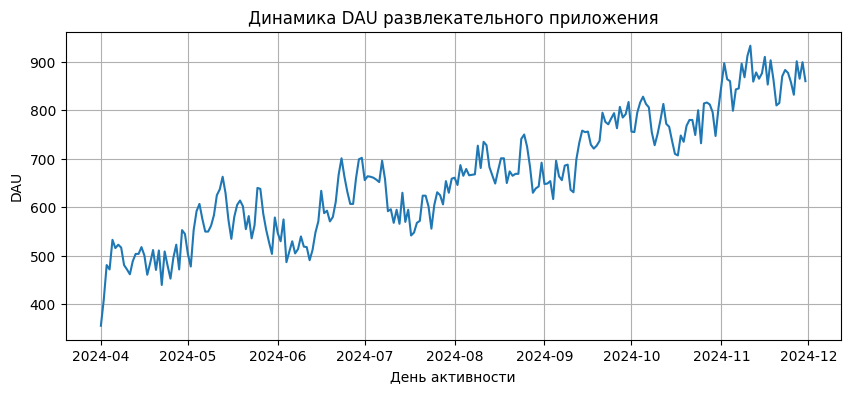

In [54]:
plt.figure(figsize=(10, 4))

# Строим линейный график
plt.plot(df_dau['event_day'], df_dau['dau'])

# Оформляем график
plt.grid()
plt.xticks(rotation=0)

# Добавляем подписи осей и заголовок
plt.xlabel('День активности')
plt.ylabel('DAU')
plt.title('Динамика DAU развлекательного приложения')

plt.show()

**На протяжении рассматриваемого периода наблюдается рост в 2,5 раза числа ежедневных активных пользователей с начального показателя в примерно 350 пользователей в день до почти 900 - это значит работает маркетинг. При этом рост неравномерен, наблюдается недельная цикличность. Резкие скачки могут быть связаны с влиянием выходных или праздничных дней, а также соответствовать запуску рекламы.**

### Рассчитаем и визуализируем число активных пользователей в месяц MAU.

In [55]:
# Конвертируем session_month в timestamp для корректной работы с осью времени
profiles['event_month'] = profiles['event_month'].dt.to_timestamp()

In [56]:
# Подготовим данные для визуализации: сгруппируем по месяцам и рассчитаем число пользователей
df_mau = profiles.groupby('event_month')['user_id'].nunique().reset_index(name='mau')

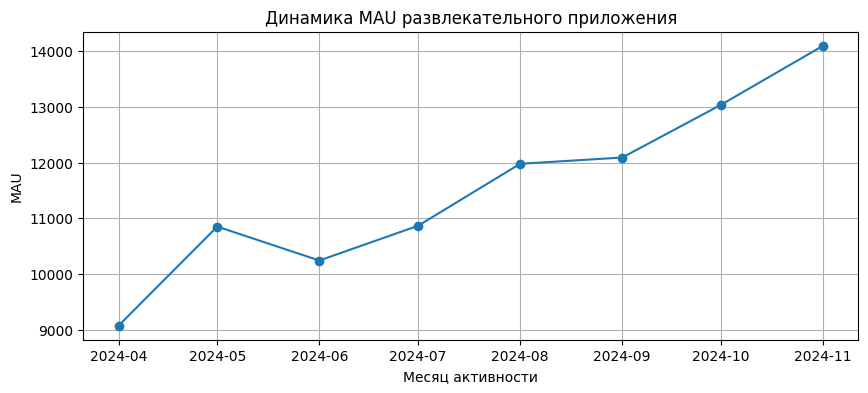

In [57]:
plt.figure(figsize=(10, 4))

# Строим линейный график 
plt.plot(df_mau['event_month'], df_mau['mau'], marker='o')

# Оформляем график
plt.grid()
plt.xticks(rotation=0)

# Добавляем подписи осей
plt.xlabel('Месяц активности')
plt.ylabel('MAU')

# Добавляем заголовок
plt.title('Динамика MAU развлекательного приложения')
plt.show()

**Динамика MAU также имеет тенденцию на рост. В мае наблюдается всплеск активности пользователей + 20% по сравнению с апрелем, что странно, ведь запуск нового контента и корректировки маркетинговой стратегии привлечения пользователей была проведена к началу лета. В остальные периоды рост равномерный.**

### Kоэффициент липкости Stickiness
Посмотрим насколько активно пользователи продолжают пользоваться продуктом. Для этого рассчитаем и визуализируем **коэффициент липкости Stickiness**

In [58]:
# Подготовим данные для визуализации: сгруппируем по месяцам и дняи и рассчитаем число пользователей в день
df_stickiness = profiles.groupby(['event_month','event_day'])['user_id'].count().reset_index(name='dau')
df_stickiness.head()

,event_month,event_day,dau
0,2024-04-01,2024-04-01,356
1,2024-04-01,2024-04-02,410
2,2024-04-01,2024-04-03,481
3,2024-04-01,2024-04-04,472
4,2024-04-01,2024-04-05,533


In [59]:
# Агрегируем данные и рассчитаем среднемесячное значение dau
df_stickiness = df_stickiness.groupby('event_month')['dau'].mean().reset_index(name='mean_dau')
df_stickiness

,event_month,mean_dau
0,2024-04-01,488.333333
1,2024-05-01,576.967742
2,2024-06-01,580.366667
3,2024-07-01,615.000000
4,2024-08-01,681.193548
5,2024-09-01,724.100000
6,2024-10-01,773.193548
7,2024-11-01,868.133333


In [60]:
# Объединим данные среднемесячного dau с mau
df_stickiness = df_stickiness.merge(df_mau, on='event_month', how='left')

# Рассчитаем коэффициент липкости
df_stickiness['stickiness'] = df_stickiness['mean_dau'] / df_stickiness['mau'] * 100

df_stickiness

,event_month,mean_dau,mau,stickiness
0,2024-04-01,488.333333,9069,5.384644
1,2024-05-01,576.967742,10849,5.318165
2,2024-06-01,580.366667,10240,5.667643
3,2024-07-01,615.000000,10864,5.660898
4,2024-08-01,681.193548,11977,5.687514
5,2024-09-01,724.100000,12089,5.989743
6,2024-10-01,773.193548,13036,5.931218
7,2024-11-01,868.133333,14097,6.158284


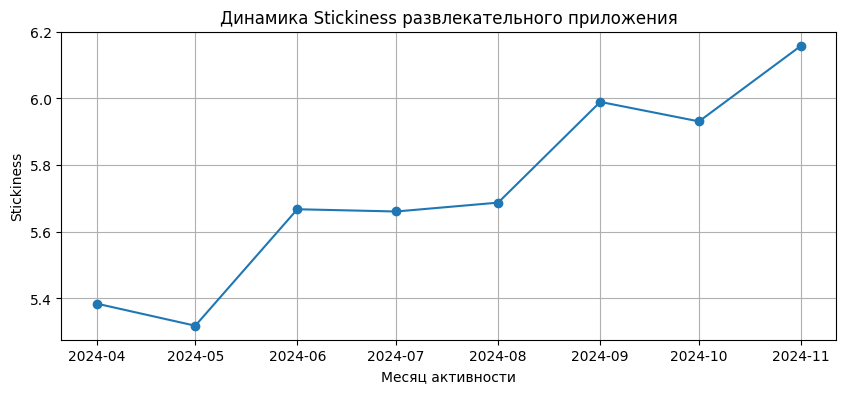

In [61]:
plt.figure(figsize=(10, 4))

# Строим линейный график 
plt.plot(df_stickiness['event_month'], df_stickiness['stickiness'], marker='o')

# Оформляем график
plt.grid()
plt.xticks(rotation=0)

# Добавляем подписи осей и заголовок
plt.xlabel('Месяц активности')
plt.ylabel('Stickiness')
plt.title('Динамика Stickiness развлекательного приложения')

plt.show()

**В апреле ежедневно приложением пользуются 5,4% пользователей от месячной аудитории. В мае метрика снижается до 5,3%, что вероятно связано с увеличением число месячной аудитории на 20%. В летние месяцы наблюдается стабилизация метрики, а в осенне-зимний период рост возобновляется с небольшим снижением в октябре  
В целом наблюдаем рост метрики с июня, когда был введен новый контент, значит пользователи больше вовлекаются в продукт.**

### Cтоимость привлечения пользователей САС
**Рассчитаем среднюю стоимость привлечения пользователей САС** в разрезе каждого месяца привлечения новых пользователей.  
Агрегируем таблицу `df_cac`, сгруппировав по первому месяцу активности, и рассчитаем суммарную стоимость затрат на привлечение пользователя и количество пользователей в месяц. Далее рассчитаем среднее значение САС в месяц на пользователя.

In [62]:
# Агрегируем данные по первому месяцу, чтобы получить общую сумму затрат и число пользователей
df_cac_monthly = df_cac.groupby(['first_month'])[['costs','users_count']].sum().reset_index()

In [63]:
# Рассчитаем среднее значение 'cac' по месяцам
df_cac_monthly['mean_cac'] = df_cac_monthly['costs'] / df_cac_monthly['users_count']

In [64]:
df_cac_monthly

,first_month,costs,users_count,mean_cac
0,2024-04,6663.052333,9069,0.734706
1,2024-05,7327.775412,9789,0.748572
2,2024-06,8492.116887,8719,0.973978
3,2024-07,9217.078561,8742,1.054344
4,2024-08,10999.013650,9518,1.155601
5,2024-09,10838.014747,9198,1.178301
6,2024-10,12595.403113,9520,1.323047
7,2024-11,13598.849128,10301,1.320148


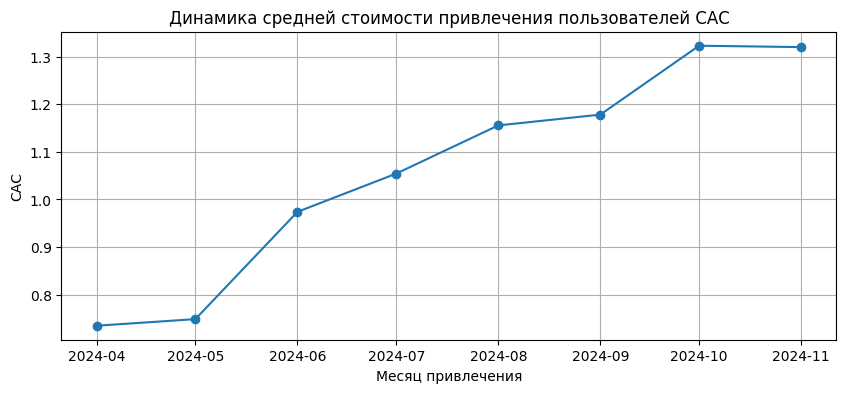

In [65]:
# Конвертируем session_month в timestamp для корректной работы с осью времени
df_cac_monthly['first_month'] = df_cac_monthly['first_month'].dt.to_timestamp()

plt.figure(figsize=(10, 4))

# Строим линейный график 
plt.plot(df_cac_monthly['first_month'], df_cac_monthly['mean_cac'], marker='o')

# Оформляем график
plt.grid()
plt.xticks(rotation=0)

# Добавляем подписи осей
plt.xlabel('Месяц привлечения')
plt.ylabel('САС')

# Добавляем заголовок
plt.title('Динамика средней стоимости привлечения пользователей САС')
plt.show()

**График демонстрирует, что с течением времени стоимость привлечения пользователя в развлекательное приложение только растет. Незначительный рост в мае (не превышает 2%). Наибольший скачок  (+ 30%) приходится на июнь, возможно такой рост связан с необходимостью популяризации нового контента. Кроме того, в начале лета была скорректирована маркетинговая стратегия, что вероятно повлияло на стоимость привлечения.**

### Рассчитаем прибыль, которую приносит пользователь - LTV     
Согласно бизнес-модели продукта, пользователь должен окупиться за 28 дней, поэтому нас в первую очередь будет интересовать прибыль, которую пользователь приносит в первые 28 дней. Отфильтруем датафрейм `profiles` и оставим для каждого пользователя только записи за первые 28 дней после привлечения.  
Рассчитаем и визуализируем среднее значение LTV для каждого месяца привлечения.

In [66]:
# Оставим события за первые 28 дней с момента привлечения
profiles_four_weeks = profiles[profiles['n_day'] < 28 ]

In [67]:
# Отфильтруем датафрейм, удалив из выборки записи за ноябрь, чтобы исключить искажения расчитываемых метрик
profiles_four_weeks_oct = profiles_four_weeks[profiles_four_weeks['first_month'] <= '2024-10-01']

In [68]:
# Для каждой когорты и каждого пользователя находим прибыль, которую он принес за 28 дней
df_ltv_four_weeks_oct = profiles_four_weeks_oct.groupby(['first_month','user_id'])['revenue_per_day'].sum().reset_index(name='total_revenue')

In [69]:
# Для каждой когорты находим среднее значение ltv
df_ltv_four_weeks_oct = df_ltv_four_weeks_oct.groupby('first_month')['total_revenue'].mean().reset_index(name='mean_ltv')
df_ltv_four_weeks_oct

,first_month,mean_ltv
0,2024-04,0.818793
1,2024-05,0.831725
2,2024-06,0.854208
3,2024-07,1.142920
4,2024-08,1.089205
5,2024-09,1.096042
6,2024-10,1.202701


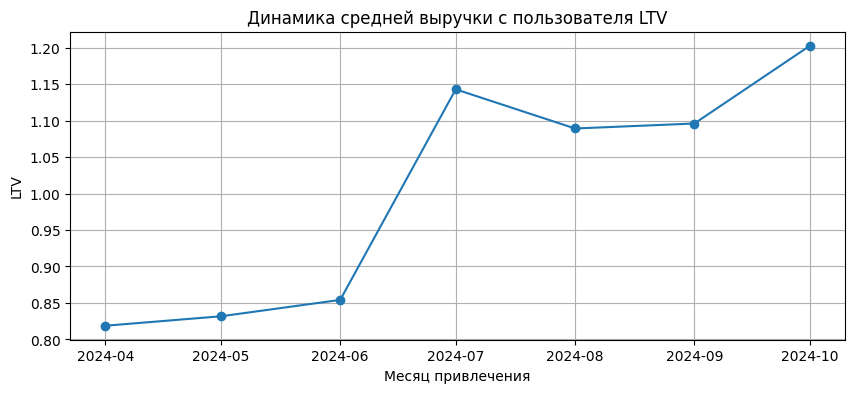

In [70]:
# Конвертируем session_month в timestamp для корректной работы с осью времени
df_ltv_four_weeks_oct['first_month'] = df_ltv_four_weeks_oct['first_month'].dt.to_timestamp()

plt.figure(figsize=(10, 4))

# Строим линейный график
plt.plot(df_ltv_four_weeks_oct['first_month'], df_ltv_four_weeks_oct['mean_ltv'], marker='o')

# Оформляем график
plt.grid()
plt.xticks(rotation=0)

# Добавляем подписи осей и зголовок
plt.xlabel('Месяц привлечения')
plt.ylabel('LTV')
plt.title('Динамика средней выручки с пользователя LTV')

plt.show()

**Выручка существенно выросла с июля по октябрь. Скачок роста приходится на июль (+34%) - вероятно новая маркетинговая стратегия дала результат.**

### Рассчитаем и визуализируем накопленный LTV для каждой когорты

In [71]:
# Сортируем значения для корректного расчёта кумулятивной суммы
profiles_four_weeks_oct = profiles_four_weeks_oct.sort_values(by=['user_id', 'event_day'])

In [72]:
# Рассчитываем LTV как кумулятивную сумму выручки одного пользователя
profiles_four_weeks_oct['ltv_cum'] = profiles_four_weeks_oct.groupby(['user_id'])['revenue_per_day'].cumsum()

In [73]:
profiles_four_weeks_oct.head()

,user_id,first_channel,first_week,first_day,event_day,event_week,event_month,lifetime,revenue_per_day,first_month,costs,users_count,cac,n_day,n_week,ltv_cum
0,26034876,FaceBoom,2024-05-27,2024-05-29,2024-05-29,2024-05-27,2024-05-01,NaN,NaN,2024-05,85.792484,90,0.953250,0,0,NaN
1,69890364,RocketSuperAds,2024-06-24,2024-06-28,2024-06-28,2024-06-24,2024-06-01,NaN,NaN,2024-06,36.295000,60,0.604917,0,0,NaN
2,75610104,FaceBoom,2024-06-03,2024-06-09,2024-06-09,2024-06-03,2024-06-01,NaN,NaN,2024-06,120.812103,101,1.196159,0,0,NaN
3,76692397,FaceBoom,2024-10-21,2024-10-21,2024-10-21,2024-10-21,2024-10-01,NaN,NaN,2024-10,138.903998,121,1.147967,0,0,NaN
4,80224421,FaceBoom,2024-06-17,2024-06-21,2024-06-21,2024-06-17,2024-06-01,NaN,NaN,2024-06,148.704623,123,1.208981,0,0,NaN


In [74]:
# Для каждой когорты, периода рассчитываем среднее значение LTV
df_ltv = profiles_four_weeks_oct.groupby(['first_month', 'lifetime'])['ltv_cum'].mean().reset_index(name='ltv')
df_ltv.head()

,first_month,lifetime,ltv
0,2024-04,0.0,3.390528
1,2024-04,1.0,5.564404
2,2024-04,2.0,7.273973
3,2024-04,3.0,8.377736
4,2024-04,4.0,8.841702


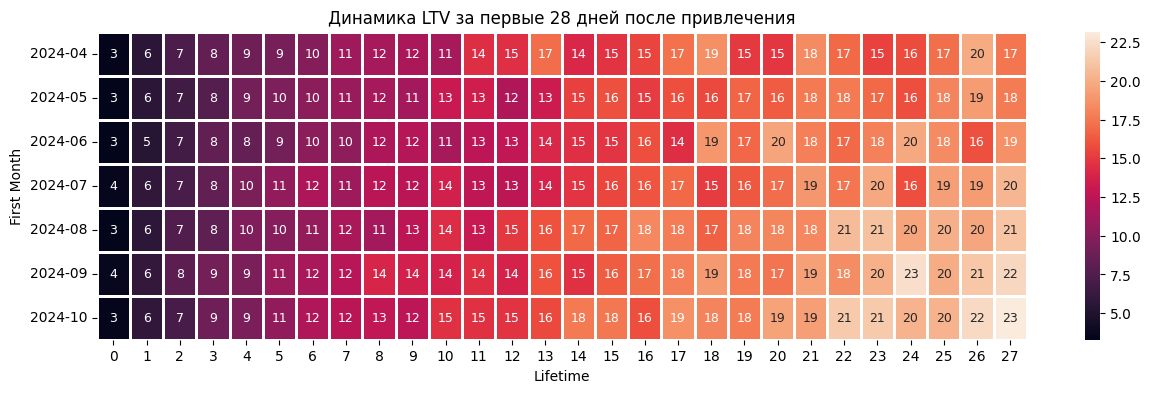

In [75]:
# Задаем размер графика
plt.figure(figsize = (15, 4))

df_ltv['lifetime'] = df_ltv['lifetime'].astype('int64')

# Создаём pivot-таблицу для визуализации LTV:
df_pivot_ltv = df_ltv.pivot(index='first_month', columns='lifetime', values='ltv')

# Строим тепловую карту:
sns.heatmap(df_pivot_ltv, annot=True, fmt='.0f', annot_kws={'size':9}, linewidths=2)

# Добавляем подписи для осей и заголовок графика
plt.title('Динамика LTV за первые 28 дней после привлечения')
plt.xlabel('Lifetime')
plt.ylabel('First Month')
plt.show()

**Для когорт, привлеченных после июня наблюдается чуть более быстрый рост LTV к концу 4 недели**

### Рассчитаем и визуализируем окупаемость инвестиций ROI
Для рассчета воспользуемся датафреймом `df_cac_monthly`с данными о затратах по месяцам и датафреймом `df_ltv_four_weeks` с средним значением ltv в месяц. Объединим их по полю `first_month` и рассчитаем значение `roi`

In [76]:
# Объединим данные ltv и cac для расчета roi
df_roi = df_cac_monthly.merge(df_ltv_four_weeks_oct, on='first_month',how='inner')

# Удаляем данные за последний месяц
df_roi_oct = df_roi[df_roi['first_month'] <= '2024-10-01']

# Рассчитываем окупаемость в процентах
df_roi_oct['roi'] = (df_roi_oct['mean_ltv'] - df_roi_oct['mean_cac']) / df_roi_oct['mean_cac'] * 100

df_roi_oct

,first_month,costs,users_count,mean_cac,mean_ltv,roi
0,2024-04-01,6663.052333,9069,0.734706,0.818793,11.444870
1,2024-05-01,7327.775412,9789,0.748572,0.831725,11.108209
2,2024-06-01,8492.116887,8719,0.973978,0.854208,-12.297015
3,2024-07-01,9217.078561,8742,1.054344,1.142920,8.401051
4,2024-08-01,10999.013650,9518,1.155601,1.089205,-5.745639
5,2024-09-01,10838.014747,9198,1.178301,1.096042,-6.981212
6,2024-10-01,12595.403113,9520,1.323047,1.202701,-9.096121


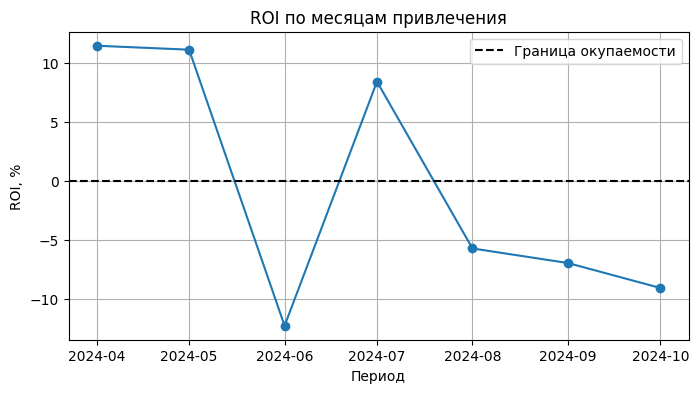

In [77]:
# Создаём график
plt.figure(figsize=(8, 4))

# Строим динамику ROI по периодам с цветами из словаря
plt.plot(df_roi_oct['first_month'], df_roi_oct['roi'], marker='o')

# Добавляем горизонтальную линию — границу окупаемости
plt.axhline(y=0, color='black', linestyle='--', label='Граница окупаемости')

# Добавляем заголовок
plt.title('ROI по месяцам привлечения')

# Добавляем подписи осей
plt.xlabel('Период')
plt.ylabel('ROI, %')

# Добавляем легенду
plt.legend()

# Добавляем сетку
plt.grid()
plt.show()

**Апрель и май характеризуются благоприятными значениями окупаемости на уровне 12.5-13%. В июне впервые метрика опустилась ниже нуля, что вероятно связано с изменением маркетинговой стратегии и стремлением расширить аудиторию приложения. В июле наблюдается кратковременное восстановление , после чего метрика только падает.**

**В целом на протяжении рассматриваемого периода наблюдается положительная динамика MAU и DAU-пользователей,  которые активно  продолжают пользоваться продуктом, что подтверждает положительная динамика Stickiness. За период наблюдений средняя стоимость привлечения пользователя САС выросла почти в два раза, причем рост начинается с июня - когда и была изменена стратегия привлечения. Кроме того,  новая стратегия привлекла пользователей, который приносят больше выручки - показатель LTV вырос в период июль-октябрь по сравнению с показателями весны.  Но вместе с тем стоимость привлечения пользователей САС  опережает рост выручки LTV, что негативно сказывается на окупаемости ROI**

## Анализ метрик в разрезе источника привлечения

### Посчитаем и визуализируем общее число привлечённых пользователей для каждого источника за все время.

In [78]:
# Агрегируем данные по каналу и рассчитаем число привлеченных пользователей
df_plot = profiles.groupby('first_channel')['user_id'].nunique().reset_index(name='count_users')
df_plot = df_plot.sort_values(by='count_users')

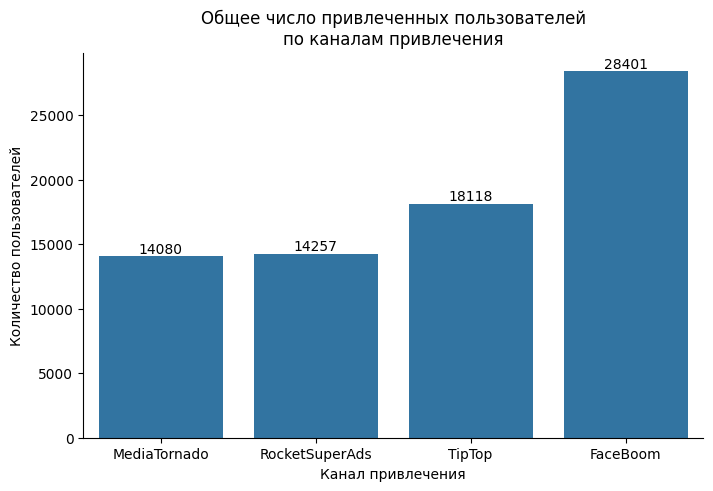

In [79]:
# Задаем размер графика
plt.figure(figsize=(8, 5))

# Строим график
fig = sns.barplot(data=df_plot, x='first_channel', y='count_users')

plt.bar_label(fig.containers[0], fmt='%.0f')
fig.spines[['top', 'right']].set_visible(False)
# Добавляем заголовок
plt.title('Общее число привлеченных пользователей\nпо каналам привлечения')

# Добавляем названия осей
plt.xlabel('Канал привлечения')
plt.ylabel('Количество пользователей')


plt.show()

**Через канала `FaceBoom` привлечено максимальное число пользователей 28401.
Для канала `TipTop` число привлеченный пользователей - 18118. А меньше всего для `PocketSuperAds` и `MediaTornado` - 14257 и 14080 соответственно**  

### Посчитаем и визуализируем общую сумму затрат на привлечение пользователей для каждого источника.

In [80]:
# Агрегируем данные по каналу и рассчитаем число привлеченных пользователей
df_plot_cac = df_cac.groupby('first_channel')['costs'].sum().reset_index(name='total_cost')
df_plot_cac = df_plot_cac.sort_values(by='total_cost')
df_plot_cac

,first_channel,total_cost
1,MediaTornado,3688.941149
2,RocketSuperAds,8744.375000
0,FaceBoom,31621.374837
3,TipTop,35676.612846


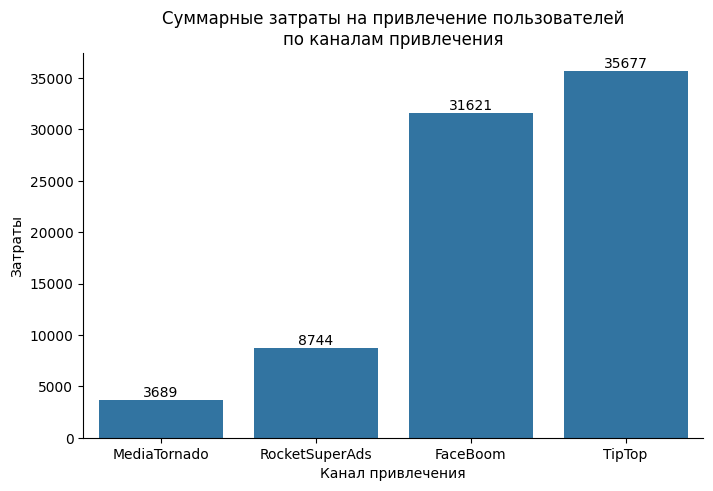

In [81]:
# Задаем размер графика
plt.figure(figsize=(8, 5))

# Строим линейный график
fig = sns.barplot(data=df_plot_cac, x='first_channel', y='total_cost')

plt.bar_label(fig.containers[0], fmt='%.0f')
fig.spines[['top', 'right']].set_visible(False)
# Добавляем заголовок
plt.title('Cуммарные затраты на привлечение пользователей\nпо каналам привлечения')

# Добавляем названия осей
plt.xlabel('Канал привлечения')
plt.ylabel('Затраты')


plt.show()

### Посчитаем и визуализируем общее число привлечённых пользователей для каждого источника по дням.

In [82]:
# Агрегируем данные по дням и каналу и рассчитаем число привлеченных пользователей
df_channel_daily = profiles.groupby(['first_day', 'first_channel'])['user_id'].nunique().reset_index(name='count_users')
df_channel_daily.head()

,first_day,first_channel,count_users
0,2024-04-01,FaceBoom,133
1,2024-04-01,MediaTornado,80
2,2024-04-01,RocketSuperAds,70
3,2024-04-01,TipTop,73
4,2024-04-02,FaceBoom,94


In [83]:
df_channel_daily['total_users'] = df_channel_daily.groupby(['first_channel'])['count_users'].cumsum()

In [84]:
# Конвертируем first_dt в timestamp для корректной работы с осью времени
df_channel_daily['first_day'] = df_channel_daily['first_day'].dt.to_timestamp()

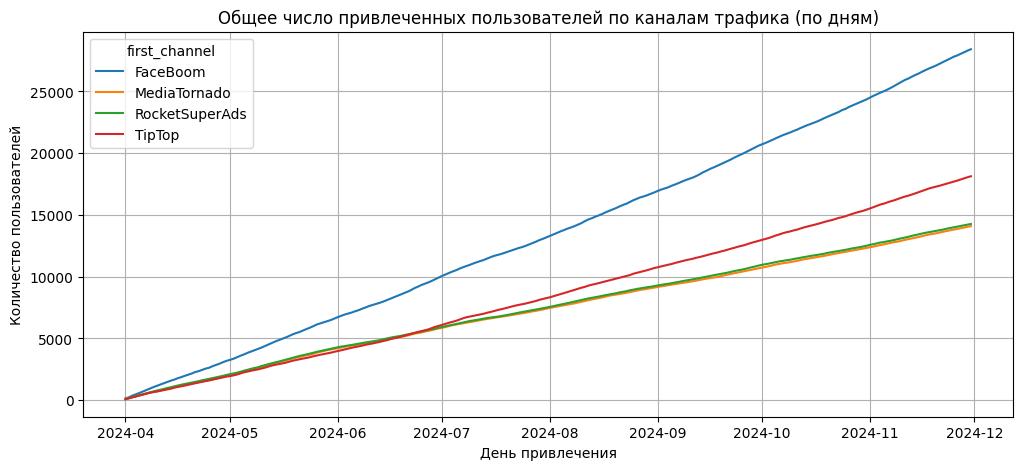

In [85]:
# Задаем размер графика
plt.figure(figsize=(12, 5))

# Строим линейный график
sns.lineplot(data=df_channel_daily, x='first_day', y='total_users', hue='first_channel')

# Устанавливаем заголовок
plt.title(f'Общее число привлеченных пользователей по каналам трафика (по дням)')

# Устанавливаем названия осей
plt.xlabel('День привлечения')
plt.ylabel('Количество пользователей')

# Добавляем сетку
plt.grid()

plt.show()

In [86]:
# Агрегируем данные по дням и каналу и рассчитаем число привлеченных пользователей
df_channel_daily_1 = profiles.groupby(['first_day', 'first_channel'])['user_id'].nunique().reset_index(name='count_users')

In [87]:
# Конвертируем first_dt в timestamp для корректной работы с осью времени
df_channel_daily_1['first_day'] = df_channel_daily_1['first_day'].dt.to_timestamp()

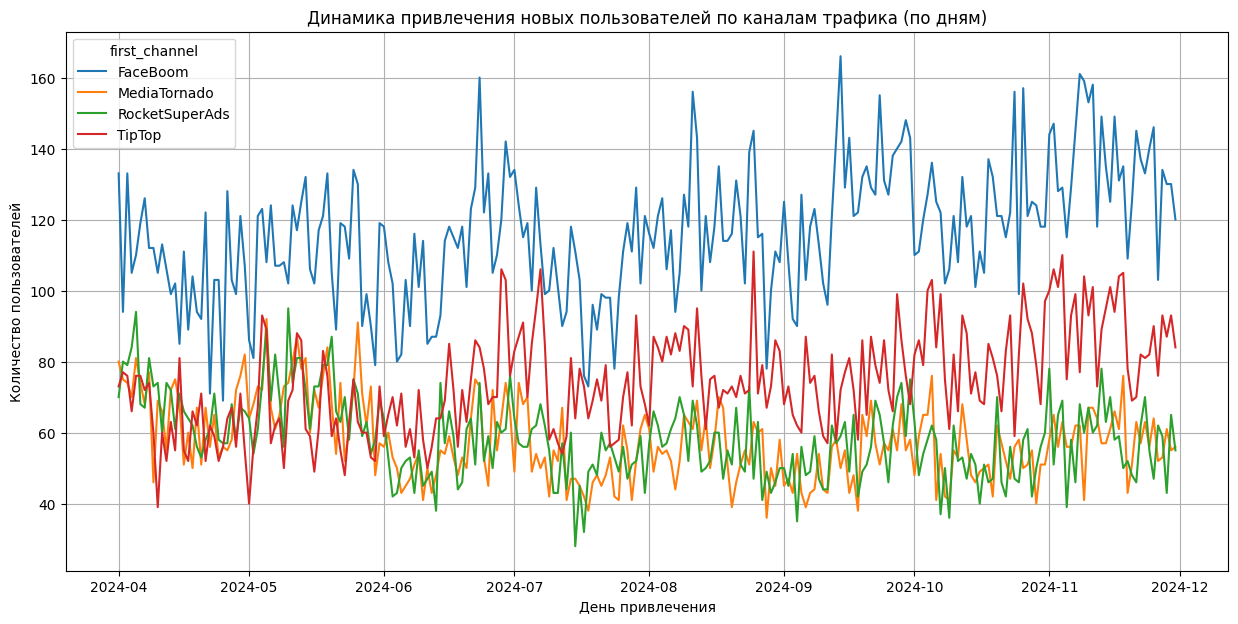

In [89]:
# Задаем размер графика
plt.figure(figsize=(15, 7))

# Строим линейный график
sns.lineplot(data=df_channel_daily_1, x='first_day', y='count_users', hue='first_channel')

# Устанавливаем заголовок
plt.title(f'Динамика привлечения новых пользователей по каналам трафика (по дням)')

# Устанавливаем названия осей
plt.xlabel('День привлечения')
plt.ylabel('Количество пользователей')

# Добавляем сетку
plt.grid()
plt.show()

**После июня для FaceBoom и TipTop наблюдается слабая положительная динамика, а для MediaTornado и RocketSuperAds слабая отрицательная. Первые каналы более активно привлекают новых пользовтелей**  

### Рассчитаем и визуализируем динамику DAU по источникам привлечения.

In [90]:
# Подготовим данные для визуализации: сгруппируем по дням, каналу и рассчитаем число пользователей
df_dau_channel = profiles.groupby(['event_day', 'first_channel'])['user_id'].nunique().reset_index(name='dau')
df_dau_channel.head()

,event_day,first_channel,dau
0,2024-04-01,FaceBoom,133
1,2024-04-01,MediaTornado,80
2,2024-04-01,RocketSuperAds,70
3,2024-04-01,TipTop,73
4,2024-04-02,FaceBoom,113


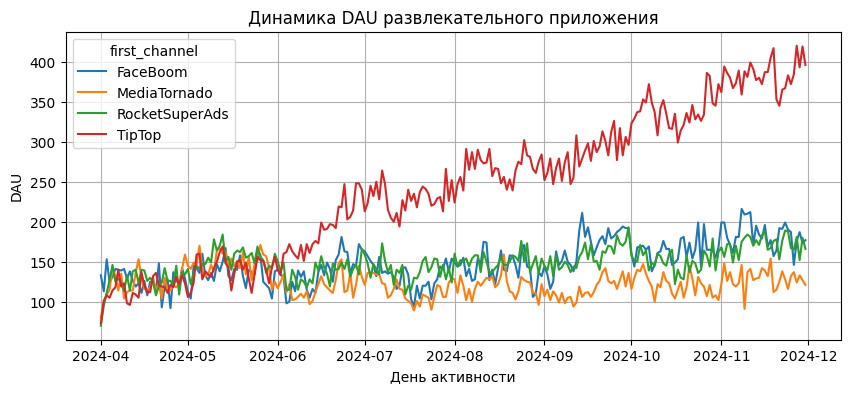

In [91]:
plt.figure(figsize=(10, 4))

# Строим линейный график
sns.lineplot(data=df_dau_channel, x='event_day', y='dau', hue='first_channel')

# Оформляем график
plt.grid()
plt.xticks(rotation=0)

# Добавляем подписи осей и заголовок
plt.xlabel('День активности')
plt.ylabel('DAU')
plt.title('Динамика DAU развлекательного приложения')

plt.show()

**Динамика DAU в апреле и мае для всех источников находится в узком коридоре от 100 до 150 активных пользователей в день. С июня, когда произошли изменения в маркетинговой кампании DAU изменил поведение для разных каналов.   
Для `MediaTornado` метрика DAU продолжила вести себя более стабильно в коридоре значений от 100-150, с небольшими колебаниями день ото дня. 
Для каналов `FaceBoom` и `PocketSuperAds` метрика DAU демонстрирует плавный рост, к концу периода - 150-200 пользователей в день.  
Для канала `TipTop` видим выраженный восходящий тренд метрики DAU, если в начале рассмативаемого периода 100-150 пользователей в день, то к концу - 350-400+.**  

### Рассчитаем и визуализируем динамику MAU по источникам привлечения.

In [92]:
# Подготовим данные для визуализации: сгруппируем по месяцам и каналам и рассчитаем число пользователей
df_mau_channel = profiles.groupby(['event_month','first_channel'])['user_id'].nunique().reset_index(name='mau')
df_mau_channel.head()

,event_month,first_channel,mau
0,2024-04-01,FaceBoom,3170
1,2024-04-01,MediaTornado,1969
2,2024-04-01,RocketSuperAds,2030
3,2024-04-01,TipTop,1900
4,2024-05-01,FaceBoom,3521


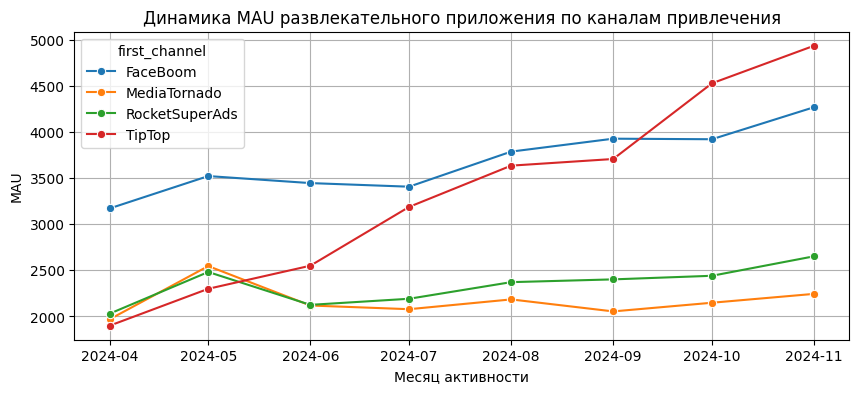

In [93]:
plt.figure(figsize=(10, 4))

# Строим линейный график
sns.lineplot(data=df_mau_channel, x='event_month', y='mau', hue='first_channel', marker='o')

# Оформляем график
plt.grid()
plt.xticks(rotation=0)

# Добавляем подписи осей и заголовок
plt.xlabel('Месяц активности')
plt.ylabel('MAU')
plt.title('Динамика MAU развлекательного приложения по каналам привлечения')

plt.show()

**Для канала `TipTop` наблюдается положительная динамика числа активных пользователей в месяц, в октябре и ноябре рост опережает канал `FaceBoom`.
Канал `FaceBoom` демонстрирует положительную динамику с небольшими снижениями в июне, июле. Каналы `PocketSuperAds` и `MediaTornado` имеют очень схожую динамику: аудитория активных пользователей растет в мае на 20%, после чего снижается практически до первоначального уровня. С июня `PocketSuperAds` ежемесячная аудитория медленно растет, а для `MediaTornado` небольшое снижение в сентябре.**

### Рассчитаем и визуализируем динамику Stickiness по источникам привлечения.

In [94]:
# Подготовим данные для визуализации: сгруппируем по месяцам, дняим и каналам привлечения и рассчитаем число пользователей в день
df_stickiness_channel = profiles.groupby(['event_month','event_day','first_channel'])['user_id'].nunique().reset_index(name='dau')
df_stickiness_channel.head()

,event_month,event_day,first_channel,dau
0,2024-04-01,2024-04-01,FaceBoom,133
1,2024-04-01,2024-04-01,MediaTornado,80
2,2024-04-01,2024-04-01,RocketSuperAds,70
3,2024-04-01,2024-04-01,TipTop,73
4,2024-04-01,2024-04-02,FaceBoom,113


In [95]:
# Рассчитаем значение среднее dau
df_stickiness_channel = df_stickiness_channel.groupby(['event_month','first_channel'])['dau'].mean().reset_index(name='mean_dau')
df_stickiness_channel.head()

,event_month,first_channel,mean_dau
0,2024-04-01,FaceBoom,126.433333
1,2024-04-01,MediaTornado,121.100000
2,2024-04-01,RocketSuperAds,124.600000
3,2024-04-01,TipTop,116.200000
4,2024-05-01,FaceBoom,135.774194


In [96]:
# Объединим данные среднего dau с mau
df_stickiness_channel = df_stickiness_channel.merge(df_mau_channel, on=['event_month','first_channel'], how='left')

# Рассчитаем коэффициент липкости
df_stickiness_channel['stickiness'] = df_stickiness_channel['mean_dau'] / df_stickiness_channel['mau'] * 100

df_stickiness_channel.head()

,event_month,first_channel,mean_dau,mau,stickiness
0,2024-04-01,FaceBoom,126.433333,3170,3.988433
1,2024-04-01,MediaTornado,121.100000,1969,6.150330
2,2024-04-01,RocketSuperAds,124.600000,2030,6.137931
3,2024-04-01,TipTop,116.200000,1900,6.115789
4,2024-05-01,FaceBoom,135.774194,3521,3.856126


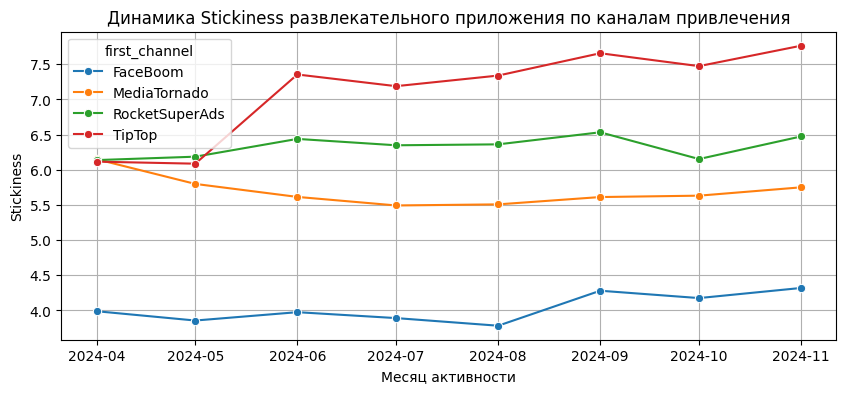

In [97]:
plt.figure(figsize=(10, 4))

# Строим линейный график
sns.lineplot(
    data=df_stickiness_channel,
    x='event_month',
    y='stickiness',
    hue='first_channel',
    marker='o')

# Оформляем график
plt.grid()
plt.xticks(rotation=0)

# Добавляем подписи осей
plt.xlabel('Месяц активности')
plt.ylabel('Stickiness')

# Добавляем заголовок
plt.title('Динамика Stickiness развлекательного приложения по каналам привлечения')
plt.show()

**В апреле и мае показатель липкости для  каналов `TipTop`,  `PocketSuperAds` и `MediaTornado` был на уровне 6%. С июня изменение в маркетинговой стратегии по-разному повлияло на показатель Stickiness:**
* **Для `TipTop` изменение в маркетинге способствовало увеличению вовлеченности, пользователи с каждым месяцем все чаще стали ежедневно возвращаться в приложение.**
* **А для каналов `PocketSuperAds` и `MediaTornado` влияние менее заметно: чуть ухудшилось для `MediaTornado` и практически не изменилось для `PocketSuperAds`.**
* **Пользователи привлеченные через `FaceBoom` менее лояльны, их уровень Stickiness на протяжении всего рассматриваемого периода колеблется около 4%. С апреля до августа практически не изменяется, не превышая уровень 4%. С сентября по ноябрь, вероятно изменения в продукте или в маркетинговой стратегии позволили хоть и незначительно, но улучшить Stickiness**


**Стоит обратить внимание на TipTop — несмотря на то что пользователей там меньше, чем у FaceBoom, они заметно активнее: это видно по высоким значениям DAU и Stickiness. Скорее всего, этот канал приводит более заинтересованную аудиторию.**


    
**У FaceBoom ситуация противоположная: по MAU видно, что пользователей много, но DAU и Stickiness остаются низкими. Такое ощущение, что люди приходят, но почти не возвращаются — возможно, канал даёт менее вовлечённый трафик.**

### Проведем анализ недельных когорт по дате привлечения и рассчитаем скользящее удержание на 14-й день с момента привлечения

In [98]:
# Отфильтруем данные и оставим когорты с полными данными
profiles_four_weeks_28_oct = profiles_four_weeks[profiles_four_weeks['first_week'] <= '2024-10-28']

# Рассчитаем число привлеченных пользователей в каждой недельной когорте в нулевой день
df_rolling_retention = profiles_four_weeks_28_oct[profiles_four_weeks_28_oct['n_day'] == 0].groupby(['first_channel', 'first_week'])['user_id'].nunique().reset_index(name='count_users_total')
df_rolling_retention.head()

,first_channel,first_week,count_users_total
0,FaceBoom,2024-04-01,820
1,FaceBoom,2024-04-08,749
2,FaceBoom,2024-04-15,697
3,FaceBoom,2024-04-22,676
4,FaceBoom,2024-04-29,747


In [99]:
# Рассчитаем число пользователей в каждой недельной когорте с 14 по 28 день
df_rolling_retention_14 = profiles_four_weeks_28_oct[profiles_four_weeks_28_oct['n_day'] >= 14].groupby(['first_channel', 'first_week'])['user_id'].nunique().reset_index(name='count_users')
df_rolling_retention_14.head()

,first_channel,first_week,count_users
0,FaceBoom,2024-04-01,10
1,FaceBoom,2024-04-08,10
2,FaceBoom,2024-04-15,12
3,FaceBoom,2024-04-22,10
4,FaceBoom,2024-04-29,12


In [100]:
# Объединяем общее число привлеченных пользователей с пользователями вернувшимися с 14 по 28 день
df_rolling_retention = df_rolling_retention.merge(df_rolling_retention_14, on=['first_channel', 'first_week'], how='left')
df_rolling_retention.head()

,first_channel,first_week,count_users_total,count_users
0,FaceBoom,2024-04-01,820,10
1,FaceBoom,2024-04-08,749,10
2,FaceBoom,2024-04-15,697,12
3,FaceBoom,2024-04-22,676,10
4,FaceBoom,2024-04-29,747,12


In [101]:
# Рассчитаем скользящее удержание на 14 день в процентах
df_rolling_retention['rr'] = df_rolling_retention['count_users'] / df_rolling_retention['count_users_total'] * 100
df_rolling_retention.head()

,first_channel,first_week,count_users_total,count_users,rr
0,FaceBoom,2024-04-01,820,10,1.219512
1,FaceBoom,2024-04-08,749,10,1.335113
2,FaceBoom,2024-04-15,697,12,1.721664
3,FaceBoom,2024-04-22,676,10,1.479290
4,FaceBoom,2024-04-29,747,12,1.606426


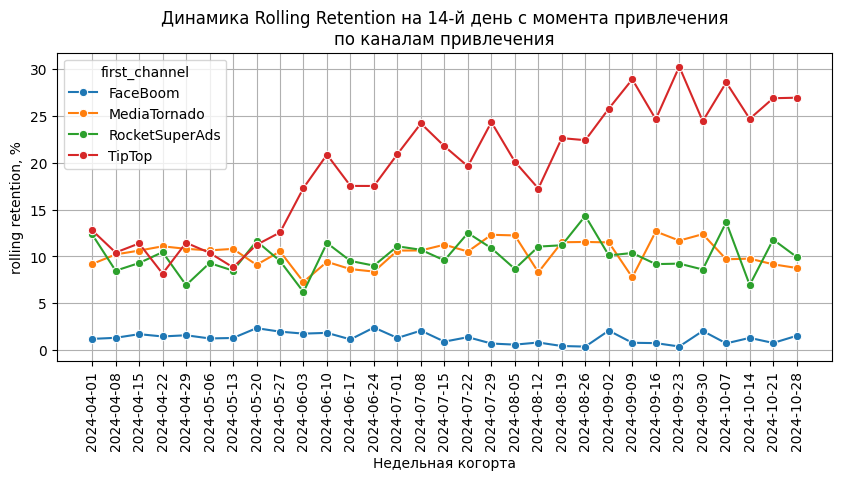

In [102]:
plt.figure(figsize=(10, 4))

# Строим линейный график
sns.lineplot(data=df_rolling_retention, x='first_week', y='rr', hue='first_channel', marker='o')

# Оформляем график
plt.xticks(df_rolling_retention['first_week'].unique(), rotation=90)
plt.grid()

# Добавляем подписи осей и заголовок
plt.xlabel('Недельная когорта')
plt.ylabel('rolling retention, %')
plt.title('Динамика Rolling Retention на 14-й день с момента привлечения\nпо каналам привлечения')

plt.show()

**Для первых 10 недельных когорт канала `TipTop` процент rolling retention составляет от 9-13%. В начале июня внесение изменений в приложение и пересмотр маркетинговой стратегии способствовало увеличению скользящего удержания до 25% для когорт летнего периода и до 31% - для осеннего.  
Для всех недельных когорот каналов `RocketSuperAds` и `MediaTornado` rolling retention ведет себя относительно стабильно на уровне 7-14%.  
Как более ранние, так и более поздние когорты канала `FaceBoom` имеют минимальное значение rolling retention на 14 день на уровне 1-2,5%**

### Рассчитаем конверсию в покупку для каждой недельной когорты в разрезе источника привлечения

In [103]:
# Найдем число пользователей для каждой когорты и канала привлечения
df_cr_week = profiles_four_weeks_28_oct.groupby(['first_channel', 'first_week'])['user_id'].nunique().reset_index(name='count_users')
df_cr_week.head()

,first_channel,first_week,count_users
0,FaceBoom,2024-04-01,820
1,FaceBoom,2024-04-08,749
2,FaceBoom,2024-04-15,697
3,FaceBoom,2024-04-22,676
4,FaceBoom,2024-04-29,747


In [104]:
# Найдем число лояльных пользователей для каждой когорты и канала привлечения
df_customer = profiles_four_weeks_28_oct[profiles_four_weeks_28_oct['lifetime'] >= 0].groupby(
    ['first_channel', 'first_week'])['user_id'].nunique().reset_index(name='count_customer')
df_customer.head()

,first_channel,first_week,count_customer
0,FaceBoom,2024-04-01,93
1,FaceBoom,2024-04-08,78
2,FaceBoom,2024-04-15,88
3,FaceBoom,2024-04-22,73
4,FaceBoom,2024-04-29,89


In [105]:
# Объединим данные о количестве пользователей и количестве лояльных
df_cr_week = df_cr_week.merge(df_customer, on=['first_channel', 'first_week'], how='left')

In [106]:
# Рассчитаем конверсию в покупку
df_cr_week['cr'] = df_cr_week['count_customer']  / df_cr_week['count_users']  * 100
df_cr_week.head()

,first_channel,first_week,count_users,count_customer,cr
0,FaceBoom,2024-04-01,820,93,11.341463
1,FaceBoom,2024-04-08,749,78,10.413885
2,FaceBoom,2024-04-15,697,88,12.625538
3,FaceBoom,2024-04-22,676,73,10.798817
4,FaceBoom,2024-04-29,747,89,11.914324


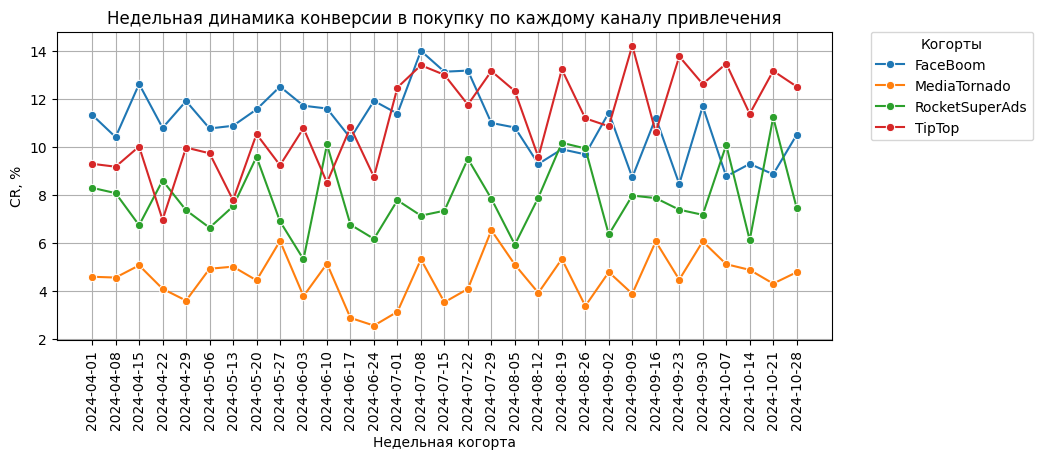

In [107]:
plt.figure(figsize=(10, 4))

# Строим линейный график
sns.lineplot(data=df_cr_week, x='first_week', y='cr', hue='first_channel', marker='o')

# Оформляем график
plt.grid()
plt.xticks(df_cr_week['first_week'].unique(),rotation=90)
plt.legend(title='Когорты', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Добавляем подписи осей и заголовок
plt.xlabel('Недельная когорта')
plt.ylabel('CR, %')
plt.title('Недельная динамика конверсии в покупку по каждому каналу привлечения')

plt.show()

**Показатель конверсии для недельных когорот канала `RocketSuperAds` варьируется от 5.6% до 11%.  
Cамый низкий показатель конверсии для когорт канала `MediaTornado` от 2.4% до 6.5%.   
Конверсии каналов `FaceBoom` и `TipTop` самые высокие среди остальных каналов и состаляют от 7% до 14,5%. В начале рассматриваемого периода наибольшая конверсия для когорт  `FaceBoom`, а к концу - для когорт `TipTop`**

### Рассчитаем недельную динамику затрат на маркетинг по каждому каналу привлечения

In [108]:
# Агрегируем данные датафрейма `df_cac`, сгруппировав по каналу и неделе
df_cac_week = df_cac.groupby(['first_week', 'first_channel'])[['costs', 'users_count']].sum().reset_index()

# Удалим данные последней недели - она неполная
df_cac_week = df_cac_week[df_cac_week['first_week'] < '2024-11-25']

df_cac_week.head()

,first_week,first_channel,costs,users_count
0,2024-04-01,FaceBoom,769.875901,820
1,2024-04-01,MediaTornado,129.318322,522
2,2024-04-01,RocketSuperAds,466.650000,542
3,2024-04-01,TipTop,393.989381,516
4,2024-04-08,FaceBoom,698.872741,749


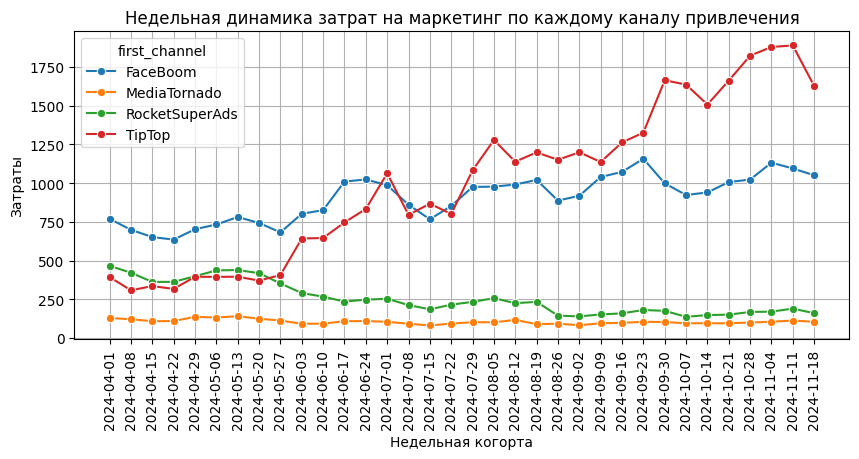

In [109]:
plt.figure(figsize=(10, 4))

# Строим линейный график
sns.lineplot(data=df_cac_week, x='first_week', y='costs', hue='first_channel', marker='o')

# Оформляем график
plt.grid()
plt.xticks(df_cac_week['first_week'].unique(), rotation=90)

# Добавляем подписи осей и заголовок
plt.xlabel('Недельная когорта')
plt.ylabel('Затраты')
plt.title('Недельная динамика затрат на маркетинг по каждому каналу привлечения')

plt.show()

**Затраты на маркетинг по каналу `MediaTornado` практически не меняются от когорты к когорте, вероятно изменение марктинговой стратегии не коснулось этого канала. По каналу `RocketSuperAds` мы видим тенденцию на снижение затрат.  Затраты на маркетинг по каналу `FaceBoom` медленно растут, для некоторых когорт наблюдается снижение затрат, но в целом восходящий тренд. Затраты на `TipTop` начинают резко расти с июня. Во второй половине наблюдаемого периода рост опережает рост затрат по каналу `FaceBoom`**

### Рассчитаем недельную динамику стоимости привлечения САС по каждому каналу привлечения
Для этого в датафрейм `df_cac_week` добавим расчетное поле CAC

In [110]:
# Рассчитаем САС
df_cac_week['cac'] = df_cac_week['costs'] / df_cac_week['users_count']

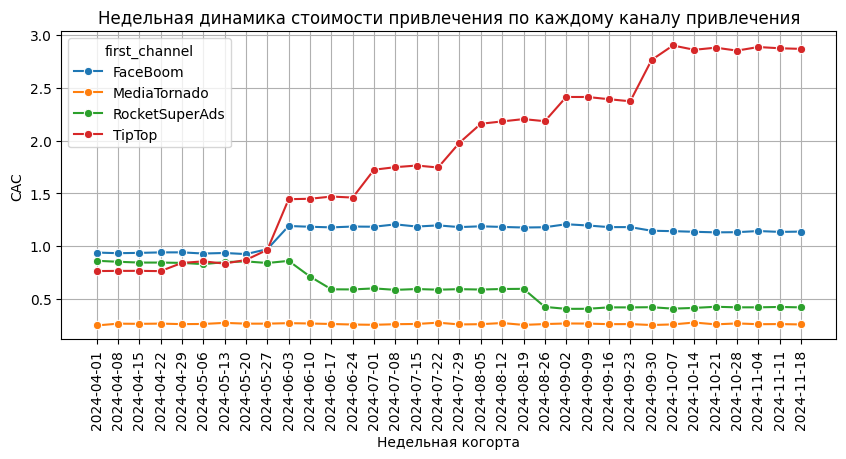

In [111]:
plt.figure(figsize=(10, 4))

# Строим линейный график
sns.lineplot(data=df_cac_week, x='first_week', y='cac', hue='first_channel', marker='o')

# Оформляем график
plt.grid()
plt.xticks(df_cac_week['first_week'].unique(), rotation=90)

# Добавляем подписи осей и заголовок
plt.xlabel('Недельная когорта')
plt.ylabel('CAC')
plt.title('Недельная динамика стоимости привлечения по каждому каналу привлечения')

plt.show()

### Рассчитаем недельную динамику LTV по каждому каналу привлечения

In [112]:
# Агрегируем данные, сгруппировав по каналу и неделе, и рассчитаем суммарную выручку по каждой когорте и каналу
df_ltv_week = profiles_four_weeks_28_oct.groupby(['first_channel', 'first_week'])['revenue_per_day'].sum().reset_index(name='revenue_total')
df_ltv_week.head()

,first_channel,first_week,revenue_total
0,FaceBoom,2024-04-01,380.36
1,FaceBoom,2024-04-08,337.06
2,FaceBoom,2024-04-15,375.41
3,FaceBoom,2024-04-22,313.09
4,FaceBoom,2024-04-29,305.00


In [113]:
# Присоединим данные с количеством пользователей в каждой когорте
df_ltv_week = df_ltv_week.merge(df_cac_week, on=['first_channel', 'first_week'], how='inner')

In [114]:
# Рассчитаем значение ltv
df_ltv_week['ltv'] = df_ltv_week['revenue_total'] /df_ltv_week['users_count'] 
df_ltv_week.head()

,first_channel,first_week,revenue_total,costs,users_count,cac,ltv
0,FaceBoom,2024-04-01,380.36,769.875901,820,0.938873,0.463854
1,FaceBoom,2024-04-08,337.06,698.872741,749,0.933074,0.450013
2,FaceBoom,2024-04-15,375.41,652.241193,697,0.935784,0.538608
3,FaceBoom,2024-04-22,313.09,635.784171,676,0.940509,0.463151
4,FaceBoom,2024-04-29,305.00,702.833939,747,0.940875,0.408300


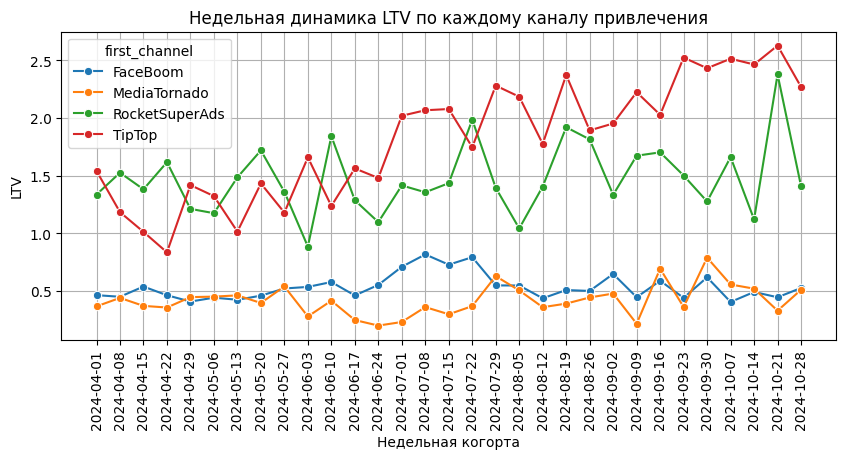

In [115]:
plt.figure(figsize=(10, 4))

# Строим линейный график
sns.lineplot(data=df_ltv_week, x='first_week', y='ltv', hue='first_channel', marker='o')

# Оформляем график
plt.grid()
plt.xticks(df_ltv_week['first_week'].unique(), rotation=90)

# Добавляем подписи осей и заголовок
plt.xlabel('Недельная когорта')
plt.ylabel('LTV')
plt.title('Недельная динамика LTV по каждому каналу привлечения')

plt.show()

### Рассчитаем ROI

In [116]:
# Добавим поле с roi
df_ltv_week['roi'] = (df_ltv_week['ltv'] - df_ltv_week['cac'] ) / df_ltv_week['cac']

In [117]:
df_ltv_week.head()

,first_channel,first_week,revenue_total,costs,users_count,cac,ltv,roi
0,FaceBoom,2024-04-01,380.36,769.875901,820,0.938873,0.463854,-0.505946
1,FaceBoom,2024-04-08,337.06,698.872741,749,0.933074,0.450013,-0.517709
2,FaceBoom,2024-04-15,375.41,652.241193,697,0.935784,0.538608,-0.424431
3,FaceBoom,2024-04-22,313.09,635.784171,676,0.940509,0.463151,-0.507553
4,FaceBoom,2024-04-29,305.00,702.833939,747,0.940875,0.408300,-0.566043


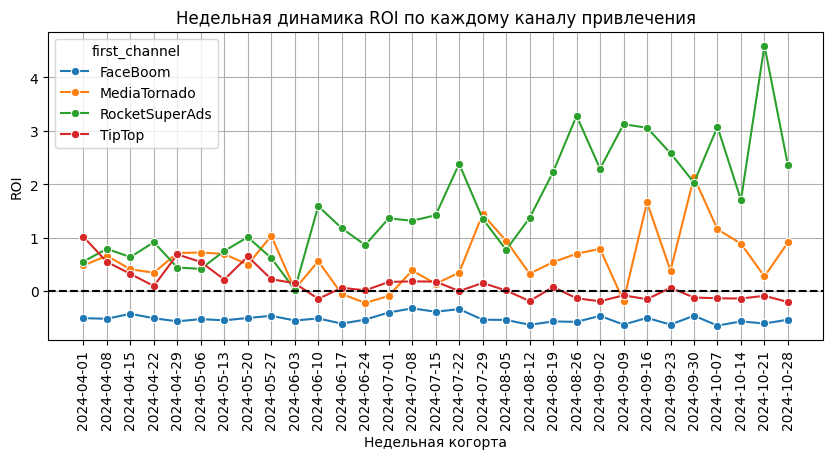

In [118]:
plt.figure(figsize=(10, 4))

# Строим линейный график
sns.lineplot(data=df_ltv_week, x='first_week', y='roi', hue='first_channel', marker='o')

# Добавляем горизонтальную линию — границу окупаемости
plt.axhline(y=0, color='black', linestyle='--', label='Граница окупаемости')

# Оформляем график
plt.grid()
plt.xticks(df_ltv_week['first_week'].unique(), rotation=90)

# Добавляем подписи осей и заголовок
plt.xlabel('Недельная когорта')
plt.ylabel('ROI')
plt.title('Недельная динамика ROI по каждому каналу привлечения')

plt.show()

**Ни для одной из когорт за период 4 недели не окупается канал `FaceBoom`, возможно для его окупаемости требуется гораздо больше времени. При этом он и до внедрения изменений был ниже уровня окупаемости** 


**Для более поздних когорт канала `TipTop` (после изменения маркетинговой стратегии) окупаемость снижается и выходит в "минус".** 


**Затраты на рекламу для когорт канала `MediaTornado` в целом быстро окупаются, однако некоторые когорты не окупились за 4 недели.** 


**Самый эффективный канал `RocketSuperAds`, когорты которого окупаются за 4 недели и приносят больше всего прибыли, особенно после запуска новой маркетинговой стратегии.**

## Анализ периода окупаемости маркетинговых вложений

### Построим тепловые карты для каналов `TipTop`, `MediaTornado` и `FaceBoom`, которые не вышли к 28 дню на уровень окупаемости. В качестве периода возьмем 10 недель

In [119]:
# Для каждой покупки рассчитаем недельный лайфтайм
df_orders['lifetime_week'] = (df_orders['event_week'] - df_orders['first_week']).dt.days // 7

In [120]:
#Рассчитаем для каждого канала, каждой недели привлечения, каждого lifetime_week суммарную выручку
df_orders_agg = df_orders.groupby(['first_channel', 'first_week', 'lifetime_week'])['revenue'].sum().reset_index(name='revenue_per_week')
df_orders_agg.head()

,first_channel,first_week,lifetime_week,revenue_per_week
0,FaceBoom,2024-04-01,0,290.63
1,FaceBoom,2024-04-01,1,62.81
2,FaceBoom,2024-04-01,2,20.94
3,FaceBoom,2024-04-01,3,5.98
4,FaceBoom,2024-04-01,6,2.99


In [121]:
# Сортируем данные
df_orders_agg = df_orders_agg.sort_values(by=['first_channel', 'first_week', 'lifetime_week'])

# Создадим поле с суммой выручки накопленной к каждой неделе
df_orders_agg['total_revenue'] = df_orders_agg.groupby(
    ['first_channel', 'first_week'])['revenue_per_week'].cumsum()

df_orders_agg.head()

,first_channel,first_week,lifetime_week,revenue_per_week,total_revenue
0,FaceBoom,2024-04-01,0,290.63,290.63
1,FaceBoom,2024-04-01,1,62.81,353.44
2,FaceBoom,2024-04-01,2,20.94,374.38
3,FaceBoom,2024-04-01,3,5.98,380.36
4,FaceBoom,2024-04-01,6,2.99,383.35


* Сумма затрат по неделям и каналам

In [122]:
#Находим затраты по неделям
df_cac_week = df_cac.groupby(['first_channel', 'first_week'])['costs'].sum().reset_index()
df_cac_week.head()

,first_channel,first_week,costs
0,FaceBoom,2024-04-01,769.875901
1,FaceBoom,2024-04-08,698.872741
2,FaceBoom,2024-04-15,652.241193
3,FaceBoom,2024-04-22,635.784171
4,FaceBoom,2024-04-29,702.833939


In [123]:
# Присоединим к данным с выручкой недельные затраты  из таблицы 'df_cac_week'
df_orders_agg = df_orders_agg.merge(df_cac_week, on=['first_channel', 'first_week'], how='inner')
df_orders_agg.head()

,first_channel,first_week,lifetime_week,revenue_per_week,total_revenue,costs
0,FaceBoom,2024-04-01,0,290.63,290.63,769.875901
1,FaceBoom,2024-04-01,1,62.81,353.44,769.875901
2,FaceBoom,2024-04-01,2,20.94,374.38,769.875901
3,FaceBoom,2024-04-01,3,5.98,380.36,769.875901
4,FaceBoom,2024-04-01,6,2.99,383.35,769.875901


* Количество привлеченных пользователей по неделям и каналам

In [124]:
# Рассчитаем количество пользователей в каждой когорте
df_count_users_week = df_visits_first.groupby(
    ['first_channel', 'first_week'])['user_id'].count().reset_index(name='count_users')
df_count_users_week.head()

,first_channel,first_week,count_users
0,FaceBoom,2024-04-01,820
1,FaceBoom,2024-04-08,749
2,FaceBoom,2024-04-15,697
3,FaceBoom,2024-04-22,676
4,FaceBoom,2024-04-29,747


In [125]:
# Присоединим данные с количеством пользователей в когортах
df_orders_agg = df_orders_agg.merge(df_count_users_week, on=['first_channel', 'first_week'], how='inner')
df_orders_agg.head()

,first_channel,first_week,lifetime_week,revenue_per_week,total_revenue,costs,count_users
0,FaceBoom,2024-04-01,0,290.63,290.63,769.875901,820
1,FaceBoom,2024-04-01,1,62.81,353.44,769.875901,820
2,FaceBoom,2024-04-01,2,20.94,374.38,769.875901,820
3,FaceBoom,2024-04-01,3,5.98,380.36,769.875901,820
4,FaceBoom,2024-04-01,6,2.99,383.35,769.875901,820


* Расчитываем САС, LTV и ROI

In [126]:
# Рассчитаем cac
df_orders_agg['cac'] = df_orders_agg['costs'] / df_orders_agg['count_users'] 

In [127]:
# Рассчитаем ltv
df_orders_agg['ltv'] = df_orders_agg['total_revenue'] / df_orders_agg['count_users'] 

In [128]:
# Рассчитаем roi
df_orders_agg['roi'] = (df_orders_agg['ltv'] - df_orders_agg['cac']) / df_orders_agg['cac']

In [129]:
df_orders_agg.head()

,first_channel,first_week,lifetime_week,revenue_per_week,total_revenue,costs,count_users,cac,ltv,roi
0,FaceBoom,2024-04-01,0,290.63,290.63,769.875901,820,0.938873,0.354427,-0.622498
1,FaceBoom,2024-04-01,1,62.81,353.44,769.875901,820,0.938873,0.431024,-0.540913
2,FaceBoom,2024-04-01,2,20.94,374.38,769.875901,820,0.938873,0.456561,-0.513714
3,FaceBoom,2024-04-01,3,5.98,380.36,769.875901,820,0.938873,0.463854,-0.505946
4,FaceBoom,2024-04-01,6,2.99,383.35,769.875901,820,0.938873,0.467500,-0.502063


In [139]:
# Отфильтруем датафрейм, оставив только первые 10 недель
df_plot = df_orders_agg.loc[df_orders_agg['lifetime_week'] <= 10].copy()

In [140]:
# Преобразуем для удобного отображение дат
df_plot['first_week'] = df_plot['first_week'].dt.date

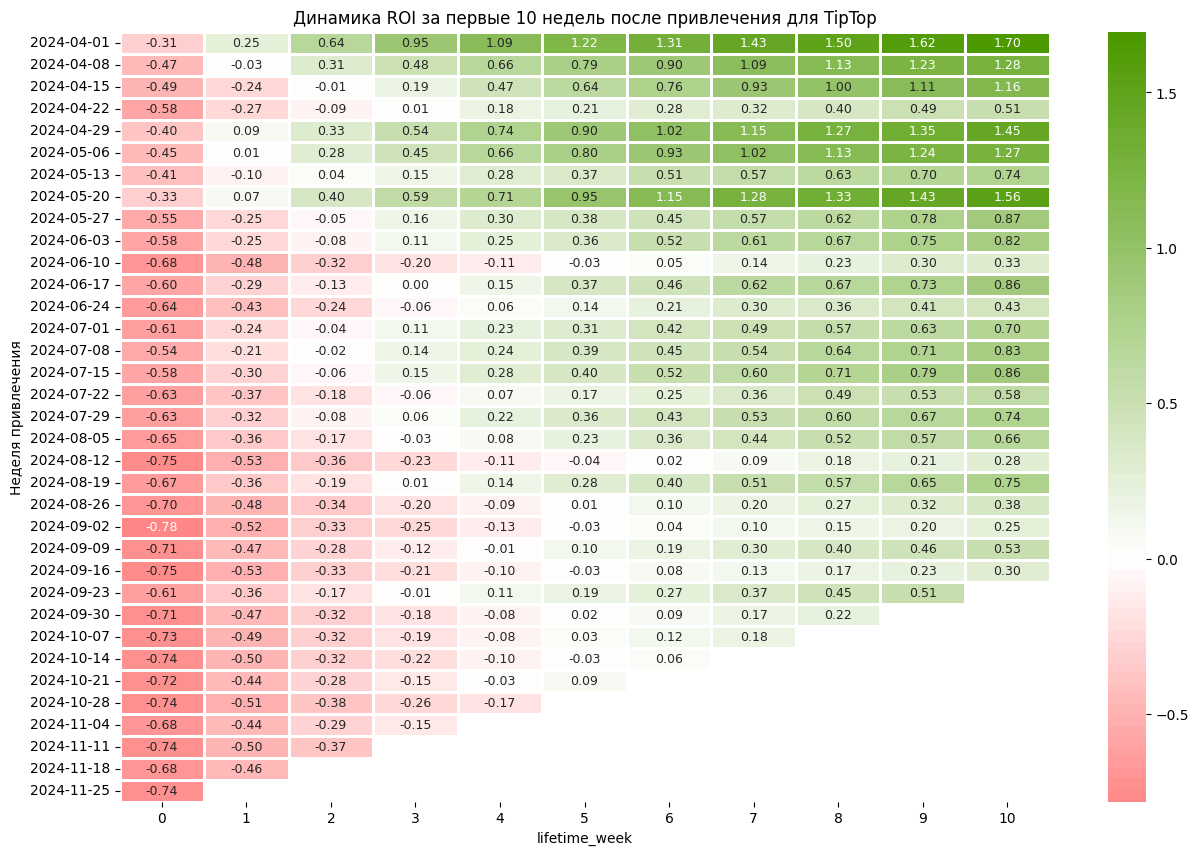

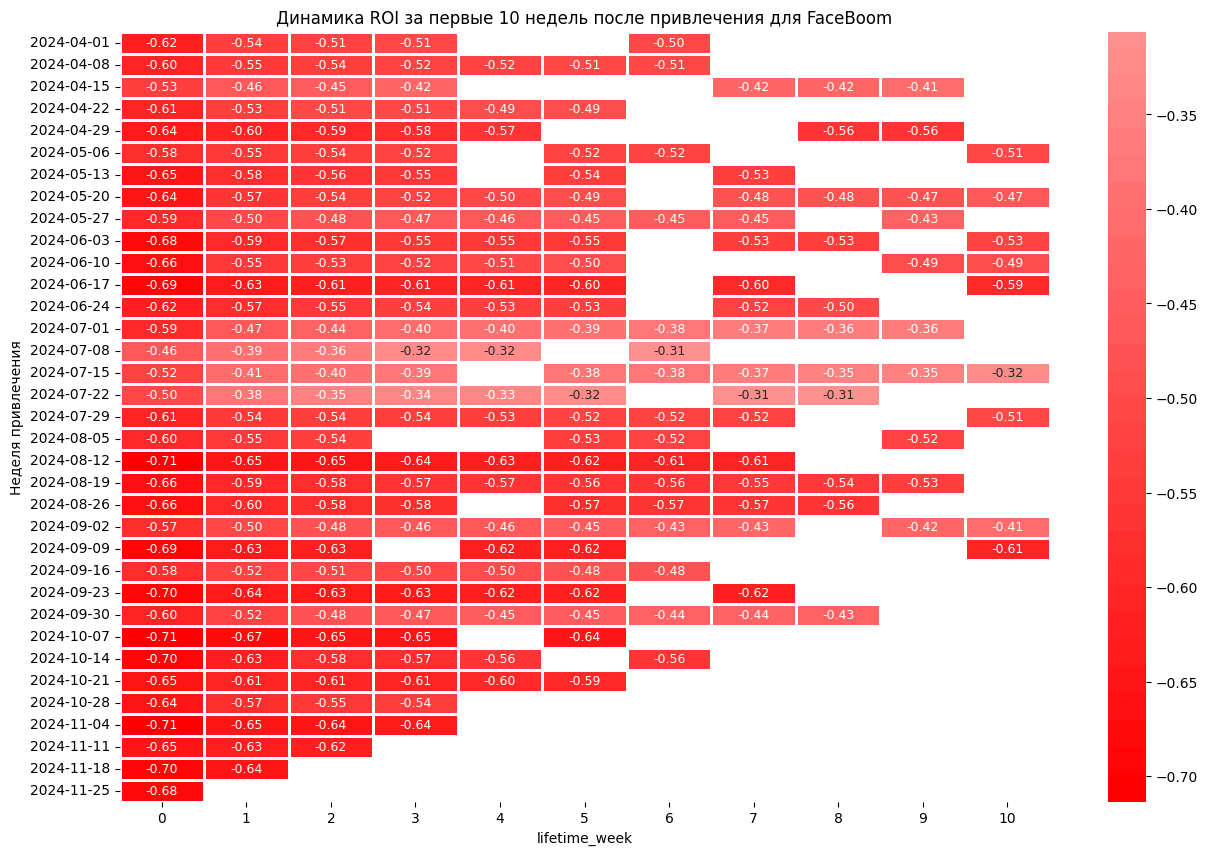

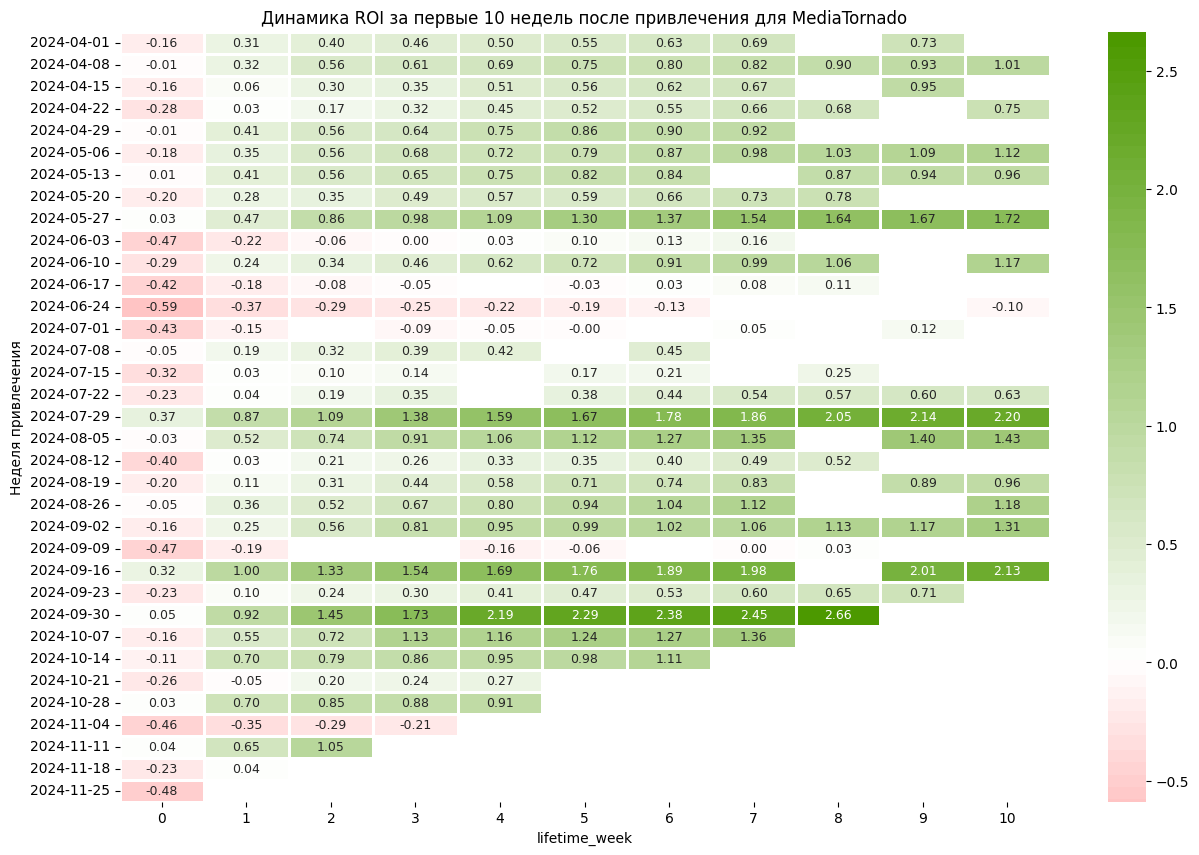

In [141]:
# Зададим цвета и палитру
colors = ['#FF0000',  '#FFFFFF', '#4C9900']
cmap = mcolors.LinearSegmentedColormap.from_list('green_red', colors, N=100)

# Зададим список каналов
channels=['TipTop', 'FaceBoom', 'MediaTornado']

for channel in channels:
    plt.figure(figsize = (15, 10))
    # Создаём pivot-таблицу для визуализации LTV:
    df_pivot = df_plot[df_plot['first_channel'] == channel].pivot(
        index='first_week', columns='lifetime_week', values='roi'
    )
    
    # Строим тепловую карту:
    sns.heatmap(df_pivot, annot=True, fmt='.2f', cmap=cmap, annot_kws={'size':9}, linewidths=2, center=0) 
    
    # Добавляем подписи для осей и заголовок графика
    plt.title(f'Динамика ROI за первые 10 недель после привлечения для {channel}')
    plt.xlabel('lifetime_week')
    plt.ylabel('Неделя привлечения')

    plt.show()

**Канал `TipTop` для всех когорт окупается за 6 недель, к 5 неделе не окупается 5 когорт. К 10 неделе не окупается единственная когорота `2024- 06-24` канала `MediaTornado`. Ниодна из когорот канала `FaceBoom` не окупается и за 10 недель**

## Выводы и рекомендации

1. **Аудитория:**  
* пользователи проявляют интерес к приложению - к концу расссматриваемого периода DAU вырос в 2,5 раза
* приложение с каждым месяцем привлекает все больше новых пользователей
* увеличивается число пользователей, которые пользуются приложением ежедневно


2. **Каналы привлечения:**
* Пользователи приходят в приложение по 4 каналам `FaceBoom`, `MediaTornado`,	`RocketSuperAds`, `TipTop`
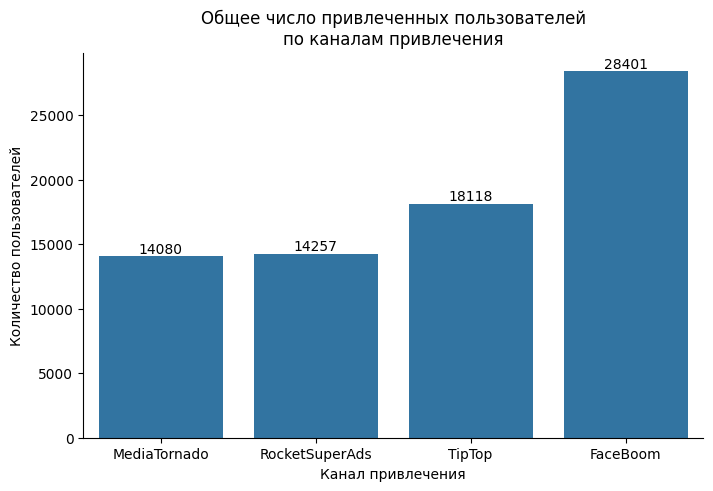  
Маркетинговые затраты распределяются следующим образом:     
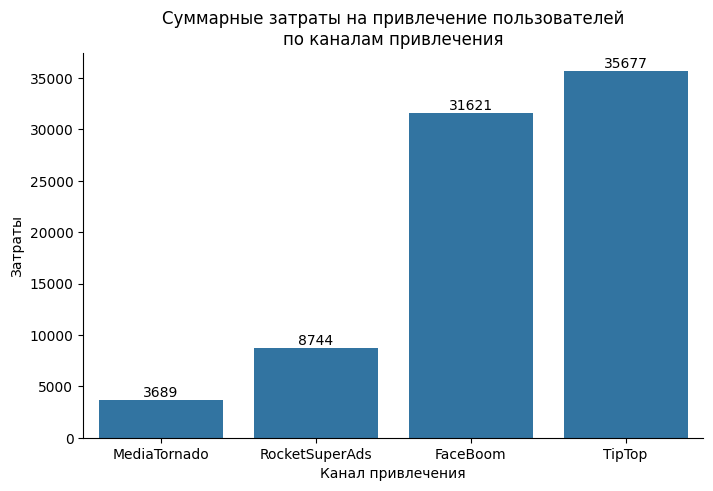  

* Несмотря на то, что канал **`FaceBoom`** ежемесячно привлекает большее число пользователей, ежедневно приложением пользуются всего около 4% :
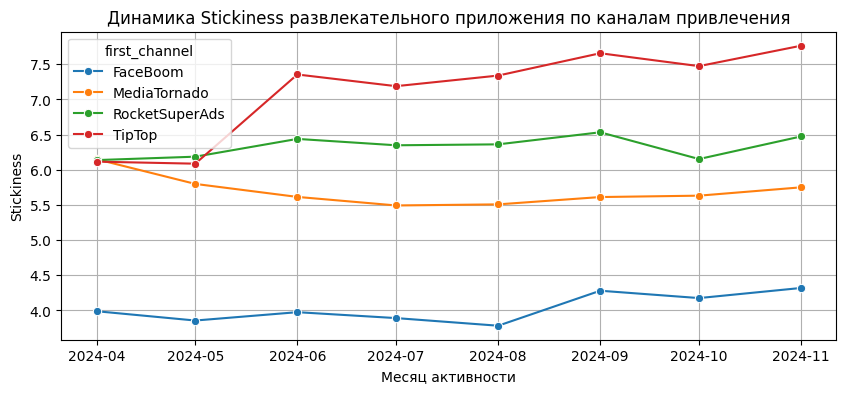  
Кроме того, скользящее удержание на 14 день после привлечение по  каналу минимально и составляет 1-2,5%:
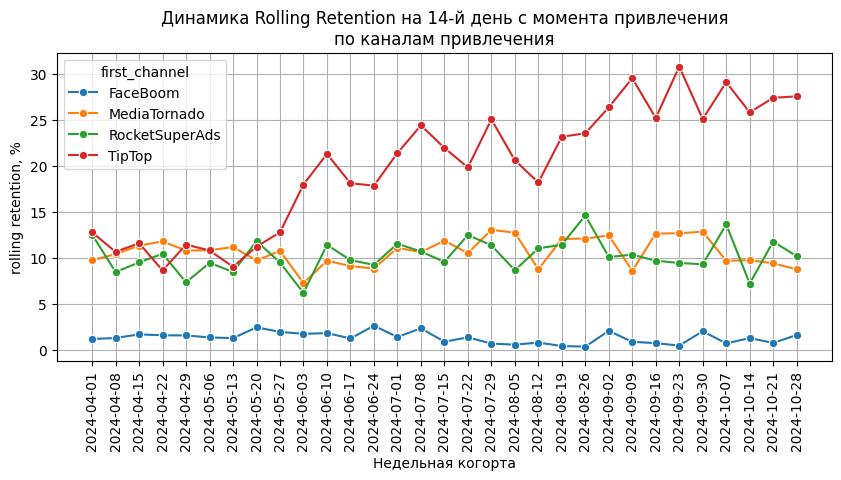  
Канал имеет хорошую конверсию в покупку, но пользователи приносят одну из самых низких прибылей:
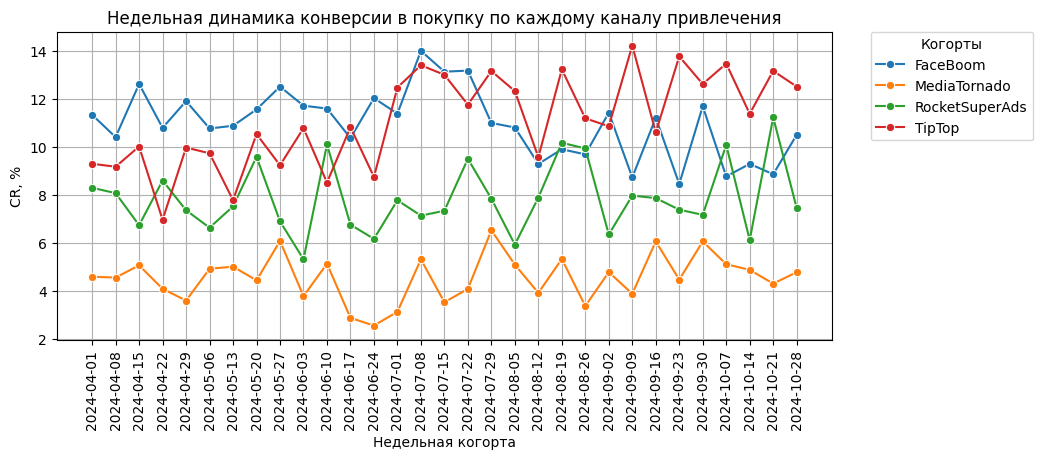  
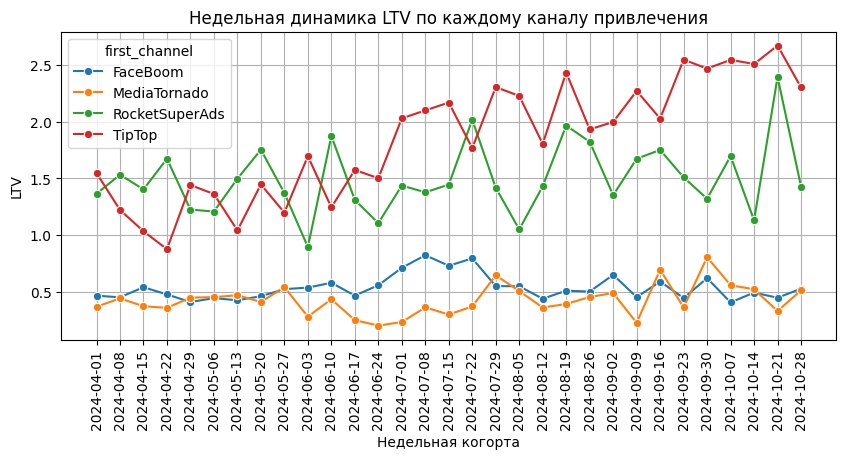  
А затраты на привлечение составляют порядка 40% от общего рекламного бюджета. В совокупности все это делает  канал убыточным. Инвестиции не окупаются и за 10 недель.

* На канал **`TipTop`** выделен большой рекламный бюджет порядка 45% от общей суммы. Канал отличается наибольшей ежедневной активностью пользователей (после внесение изменений в стратегию) и высокой вовлеченностью:
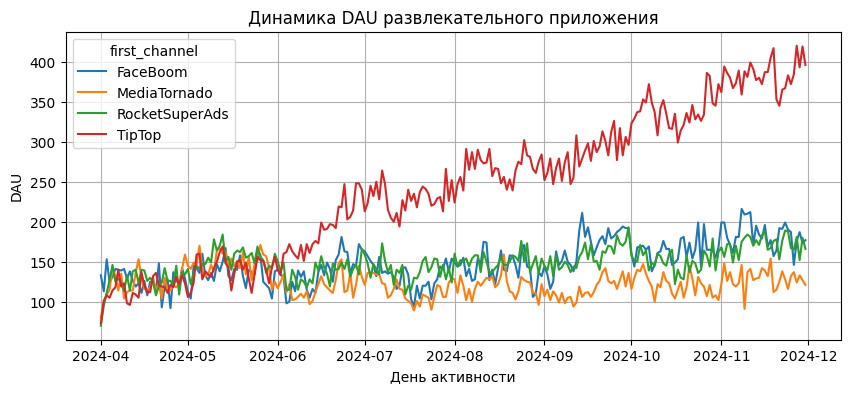  
Канал имеет высокую конверсию в покупку. Пользователи остаются активными и после 2 недель с момента привлечения. Пользователи приносят хорошую прибыль. Однако постоянное и регулярное увеличение стоимости привлечения негативно повлияло на окупаемость - пользователи не успевают окупиться за 4 недели, требуется 6 недель.


* Через каналы **`MediaTornado`** и **`RocketSuperAds`** привлечено по 19% пользователей. При этом `MediaTornado` использовал всего 5% рекламного бюджета, а `RocketSuperAds` - порядка 11%. Оба канала имеют низкий показатель активных пользователей в день и в месяц. Изменение в маркетинговой стратегии существенно не повлияли на скользящее удержание, 7-14% пользователей продолжают интересоваться приложением и после 14 дней. 

    `MediaTornado`: имеет самую низкую конверсию в покупку и самую низкую прибыль с пользователя. Но за счет низкой стоимости привлечения, бОльшая часть когорт (кроме 4) окупается за 28 дней, и лишь 1 когорта так и не окупилась за 10 недель.  

    `RocketSuperAds`: низкий уровень стоимости привлечения и достаточно высокая прибыль с пользователя позволяют окупаться каналу за 2 недели.   
    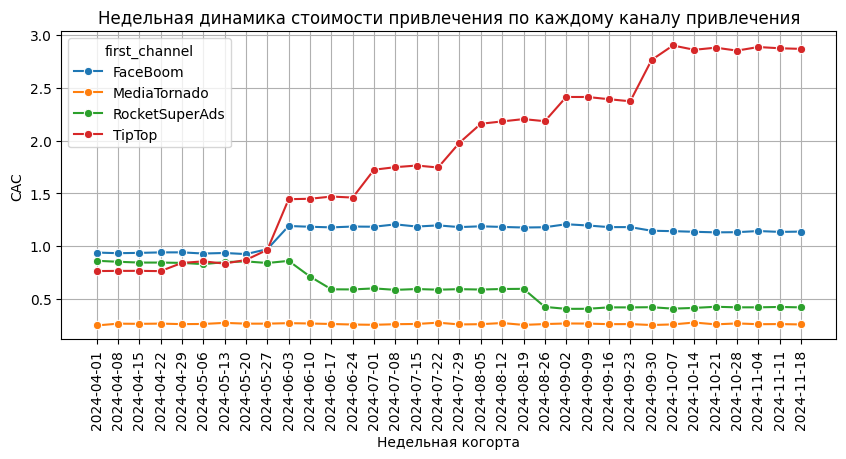



В качестве рекомендаций:
1. `FaceBoom`
* Существенно снизить вложения, оставив небольшую часть бюджета для тестирования новых стратегий, если этот канал специалисты считают перспективным.
* Полностью отказаться от убыточного канала, что позволит освободить 40% рекламного бюджета для реализации проверенных и рабочих стратегий в рамках других каналов.
2. `TipTop`
*  Стабилизировать рекламный бюджет, снизить вложения до уровня мая
*  Оставить прежний уровен вложений и быть готовыми к окупаемости инвестиций за 6 недель, при этом стоит проработать монетизацию в первые 4 недели, возможно добавить новые тарифные планы к уже существующим.
3. `MediaTornado`
* Сохранить текущий уровень бюджета
4. `RocketSuperAds`
* Однозначно стоит рассматривать этот канал для дополнительных рекламных вложений. При этом не допускать роста стоимости привлечения, не допускать снижения прибыли с пользователя, отслеживать уровень удержания и окупаемости, чтобы сохранить эффективность канала. 

Грамотное перераспределение рекламных бюджетов позволит улучшить прибыльность инвестиций и как следствие выручка перейдет в фазу роста.

--------------------------------------